<a href="https://colab.research.google.com/github/gre1wy/Machine_Learning/blob/main/lab1/Lab1_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display, HTML
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
import statsmodels.api as sm
from scipy.stats import norm

In [72]:
import os
import zipfile

In [73]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_info_columns', 200)

In [74]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("maso0dahmed/football-players-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'football-players-data' dataset.
Path to dataset files: /kaggle/input/football-players-data


In [75]:
csv_file = os.path.join(path, "fifa_players.csv")
data_raw = pd.read_csv(csv_file)


## About Dataset

This comprehensive dataset offers detailed information on approximately 17,000 **FIFA football players**, meticulously scraped from SoFIFA.com. (updated 2023)

It encompasses a wide array of **player-specific data points**, including but not limited to player names, nationalities, clubs, player ratings, potential, positions, ages, and various skill attributes.

Link: https://www.kaggle.com/datasets/maso0dahmed/football-players-data?select=fifa_players.csv

In [76]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17954 entries, 0 to 17953
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           17954 non-null  object 
 1   full_name                      17954 non-null  object 
 2   birth_date                     17954 non-null  object 
 3   age                            17954 non-null  int64  
 4   height_cm                      17954 non-null  float64
 5   weight_kgs                     17954 non-null  float64
 6   positions                      17954 non-null  object 
 7   nationality                    17954 non-null  object 
 8   overall_rating                 17954 non-null  int64  
 9   potential                      17954 non-null  int64  
 10  value_euro                     17699 non-null  float64
 11  wage_euro                      17708 non-null  float64
 12  preferred_foot                 17954 non-null 

## Goal

There 2 interesting features to predict wage and value of player.
My goal will be to predict **value** (value_euro)      

## Cleaning

In [77]:
data_clean = data_raw.copy()

In [78]:
def missing_values_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[missing_data['Total'] > 0]
    return missing_data

In [79]:
missing_values_table(data_clean)

Total   Percent
national_team           17097  0.952267
national_team_position  17097  0.952267
national_rating         17097  0.952267
national_jersey_number  17097  0.952267
release_clause_euro      1837  0.102317
value_euro                255  0.014203
wage_euro                 246  0.013702

In [80]:
data_clean.head(5)

name                       full_name birth_date  age  height_cm  \
0      L. Messi  Lionel Andrés Messi Cuccittini  6/24/1987   31     170.18   
1    C. Eriksen    Christian  Dannemann Eriksen  2/14/1992   27     154.94   
2      P. Pogba                      Paul Pogba  3/15/1993   25     190.50   
3    L. Insigne                 Lorenzo Insigne   6/4/1991   27     162.56   
4  K. Koulibaly               Kalidou Koulibaly  6/20/1991   27     187.96   

   weight_kgs  positions nationality  overall_rating  potential   value_euro  \
0        72.1   CF,RW,ST   Argentina              94         94  110500000.0   
1        76.2  CAM,RM,CM     Denmark              88         89   69500000.0   
2        83.9     CM,CAM      France              88         91   73000000.0   
3        59.0      LW,ST       Italy              88         88   62000000.0   
4        88.9         CB     Senegal              88         91   60000000.0   

   wage_euro preferred_foot  international_reputation(1-5)  weak_foot(1-5)  \
0   565000.0           Left                              5               4   
1   205000.0          Right                              3               5   
2   255000.0          Right                              4               4   
3   165000.0          Right                              3               4   
4   135000.0          Right                              3               3   

   skill_moves(1-5) body_type  release_clause_euro national_team  \
0                 4     Messi          226500000.0     Argentina   
1                 4      Lean          133800000.0       Denmark   
2                 5    Normal          144200000.0        France   
3                 4    Normal          105400000.0         Italy   
4                 2    Normal          106500000.0           NaN   

   national_rating national_team_position  national_jersey_number  crossing  \
0             82.0                     RF                    10.0        86   
1             78.0                    CAM                    10.0        88   
2             84.0                    RDM                     6.0        80   
3             83.0                     LW                    10.0        86   
4              NaN                    NaN                     NaN        30   

   finishing  heading_accuracy  short_passing  volleys  dribbling  curve  \
0         95                70             92       86         97     93   
1         81                52             91       80         84     86   
2         75                75             86       85         87     85   
3         77                56             85       74         90     87   
4         22                83             68       14         69     28   

   freekick_accuracy  long_passing  ball_control  acceleration  sprint_speed  \
0                 94            89            96            91            86   
1                 87            89            91            76            73   
2                 82            90            90            71            79   
3                 77            78            93            94            86   
4                 28            60            63            70            75   

   agility  reactions  balance  shot_power  jumping  stamina  strength  \
0       93         95       95          85       68       72        66   
1       80         88       81          84       50       92        58   
2       76         82       66          90       83       88        87   
3       94         83       93          75       53       75        44   
4       50         82       40          55       81       75        94   

   long_shots  aggression  interceptions  positioning  vision  penalties  \
0          94          48             22           94      94         75   
1          89          46             56           84      91         67   
2          82          78             64           82      88         82   
3          84        

### name, full_name, birth_date

In [81]:
# dont need name and full_name, but keep full_name for exploration
data_clean.drop('name', axis=1, inplace=True, errors='ignore')

# dont need birth_date, because we have age
data_clean.drop('birth_date', axis=1, inplace=True, errors='ignore')

### positions

In [82]:
# need to make positions acceptable for the model

# remove spaces
data_clean['positions'] = data_clean['positions'].str.replace(r'\s+', '', regex=True)
# convert to dummies
positions_dummies = data_clean['positions'].str.get_dummies(sep=',')
# add to the dataset
data_clean = pd.concat([data_clean, positions_dummies], axis=1)

data_clean.drop('positions', axis=1, inplace=True)

In [83]:
position_cols = ['CAM', 'CB', 'CDM', 'CF', 'CM', 'GK', 'LB', 'LM', 'LW', 'LWB', 'RB', 'RM', 'RW', 'RWB', 'ST']

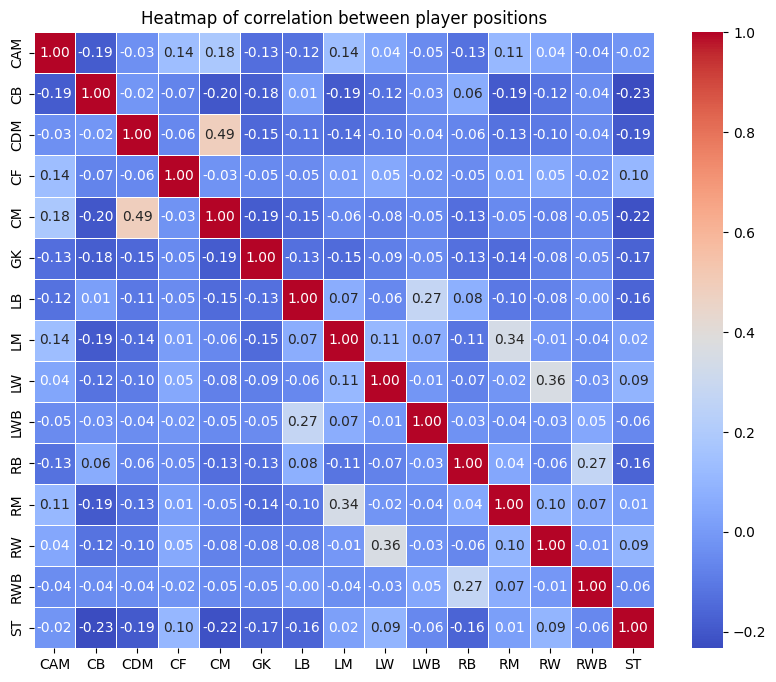

In [84]:
correlation_matrix = data_clean[position_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
)
plt.title('Heatmap of correlation between player positions')
plt.show()

In [85]:
data_clean[position_cols].describe()

CAM            CB           CDM            CF            CM  \
count  17954.000000  17954.000000  17954.000000  17954.000000  17954.000000   
mean       0.121700      0.204690      0.150329      0.020163      0.211374   
std        0.326948      0.403486      0.357403      0.140560      0.408294   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 GK            LB            LM            LW           LWB  \
count  17954.000000  17954.000000  17954.000000  17954.000000  17954.000000   
mean       0.115016      0.113568      0.140414      0.053303      0.016654   
std        0.319050      0.317295      0.347426      0.224643      0.127974   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 RB            RM            RW           RWB            ST  
count  17954.000000  17954.000000  17954.000000  17954.000000  17954.000000  
mean       0.114571      0.136571      0.052412      0.017489      0.176729  
std        0.318512      0.343404      0.222862      0.131089      0.381450  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000      0.000000      0.000000  
75%        0.000000      0.000000      0.000000      0.000000      0.000000  
max        1.000000      1.000000      1.000000      1.000000      1.000000

Since in football such pairs of positions as CF - ST, LWB - LW, RWB - RW have only a formal difference and there are not enough first positions in the dataset, we will combine them.

In [86]:
data_clean['ST'] = data_clean['CF'] | data_clean['ST']
data_clean['LW'] = data_clean['LWB'] | data_clean['LW']
data_clean['LW'] = data_clean['RWB'] | data_clean['RW']
cols_to_drop = ['CF', 'LWB', 'RWB']
data_clean = data_clean.drop(columns=cols_to_drop)

In [87]:
position_cols_new = set(position_cols) - set(cols_to_drop)

In [88]:
data_clean[list(position_cols_new)].describe()

LM            LB           CDM            GK            CM  \
count  17954.000000  17954.000000  17954.000000  17954.000000  17954.000000   
mean       0.140414      0.113568      0.150329      0.115016      0.211374   
std        0.347426      0.317295      0.357403      0.319050      0.408294   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 CB           CAM            RW            LW            RM  \
count  17954.000000  17954.000000  17954.000000  17954.000000  17954.000000   
mean       0.204690      0.121700      0.052412      0.069232      0.136571   
std        0.403486      0.326948      0.222862      0.253856      0.343404   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 ST            RB  
count  17954.000000  17954.000000  
mean       0.187702      0.114571  
std        0.390485      0.318512  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        1.000000      1.000000

### preferred_foot

In [89]:
data_clean['preferred_foot'].value_counts()

preferred_foot
Right    13781
Left      4173
Name: count, dtype: int64

In [90]:
# make left_footed binary column from preferred_foot
data_clean['left_footed'] = data_clean['preferred_foot'].map({'Left': 1, 'Right': 0})

data_clean.drop('preferred_foot', axis=1, inplace=True, errors='ignore')

### body_type

In [91]:
data_clean['body_type'].value_counts()

body_type
Normal                 10393
Lean                    6468
Stocky                  1086
Messi                      1
Courtois                   1
PLAYER_BODY_TYPE_25        1
Akinfenwa                  1
Shaqiri                    1
Neymar                     1
C. Ronaldo                 1
Name: count, dtype: int64

Unique body types assigned to certain players are crucial to gameplay as they dictate special animations, particularly during dribbling.   
We performed a visual assessment of their physical build to accurately reclassify these players.

In [92]:
# but before we need to know who has PLAYER_BODY_TYPE_25 body type
player_info = data_clean[data_clean['body_type'] == 'PLAYER_BODY_TYPE_25']
player_info

full_name  age  height_cm  weight_kgs nationality  \
14  Mohamed  Salah Ghaly   26     175.26        71.2       Egypt   

    overall_rating  potential  value_euro  wage_euro  \
14              89         90  78500000.0   265000.0   

    international_reputation(1-5)  weak_foot(1-5)  skill_moves(1-5)  \
14                              3               3                 4   

              body_type  release_clause_euro national_team  national_rating  \
14  PLAYER_BODY_TYPE_25          151100000.0         Egypt             73.0   

   national_team_position  national_jersey_number  crossing  finishing  \
14                     RM                    10.0        78         90   

    heading_accuracy  short_passing  volleys  dribbling  curve  \
14                59             83       76         89     83   

    freekick_accuracy  long_passing  ball_control  acceleration  sprint_speed  \
14                 60            74            88            94            91   

    agility  reactions  balance  shot_power  jumping  stamina  strength  \
14       91         92       88          80       68       84        70   

    long_shots  aggression  interceptions  positioning  vision  penalties  \
14          83          63             55           92      84         75   

    composure  marking  standing_tackle  sliding_tackle  CAM  CB  CDM  CM  GK  \
14         91       38               43              41    0   0    0   0   0   

    LB  LM  LW  RB  RM  RW  ST  left_footed  
14   0   0   1   0   0   1   1            1

In [93]:
body_map = {
    'Messi': 'Lean',
    'Courtois': 'Normal',
    'Akinfenwa': 'Stocky',
    'Shaqiri': 'Stocky',
    'Neymar': 'Lean',
    'C. Ronaldo': 'Lean',
    'PLAYER_BODY_TYPE_25': 'Lean',
}

data_clean['body_type'] = data_clean['body_type'].replace(body_map)

In [94]:
data_clean.head(5)

full_name  age  height_cm  weight_kgs nationality  \
0  Lionel Andrés Messi Cuccittini   31     170.18        72.1   Argentina   
1    Christian  Dannemann Eriksen   27     154.94        76.2     Denmark   
2                      Paul Pogba   25     190.50        83.9      France   
3                 Lorenzo Insigne   27     162.56        59.0       Italy   
4               Kalidou Koulibaly   27     187.96        88.9     Senegal   

   overall_rating  potential   value_euro  wage_euro  \
0              94         94  110500000.0   565000.0   
1              88         89   69500000.0   205000.0   
2              88         91   73000000.0   255000.0   
3              88         88   62000000.0   165000.0   
4              88         91   60000000.0   135000.0   

   international_reputation(1-5)  weak_foot(1-5)  skill_moves(1-5) body_type  \
0                              5               4                 4      Lean   
1                              3               5                 4      Lean   
2                              4               4                 5    Normal   
3                              3               4                 4    Normal   
4                              3               3                 2    Normal   

   release_clause_euro national_team  national_rating national_team_position  \
0          226500000.0     Argentina             82.0                     RF   
1          133800000.0       Denmark             78.0                    CAM   
2          144200000.0        France             84.0                    RDM   
3          105400000.0         Italy             83.0                     LW   
4          106500000.0           NaN              NaN                    NaN   

   national_jersey_number  crossing  finishing  heading_accuracy  \
0                    10.0        86         95                70   
1                    10.0        88         81                52   
2                     6.0        80         75                75   
3                    10.0        86         77                56   
4                     NaN        30         22                83   

   short_passing  volleys  dribbling  curve  freekick_accuracy  long_passing  \
0             92       86         97     93                 94            89   
1             91       80         84     86                 87            89   
2             86       85         87     85                 82            90   
3             85       74         90     87                 77            78   
4             68       14         69     28                 28            60   

   ball_control  acceleration  sprint_speed  agility  reactions  balance  \
0            96            91            86       93         95       95   
1            91            76            73       80         88       81   
2            90            71            79       76         82       66   
3            93            94            86       94         83       93   
4            63            70            75       50         82       40   

   shot_power  jumping  stamina  strength  long_shots  aggression  \
0          85       68       72        66          94          48   
1          84       50       92        58          89          46   
2          90       83       88        87          82          78   
3          75       53       75        44          84          34   
4          55       81       75        94          15          87   

   interceptions  positioning  vision  penalties  composure  marking  \
0             22           94      94         75         96       33   
1             56           84      91         67         88       59   
2             64           82      88         82         87       63   
3             26           83      87         61         83       51   
4             88           24      49         33         80       91   

   standing_tackle  sliding_tackle  CAM  CB  CDM  CM  GK  LB  LM  L

In [95]:
data_clean['body_type'].value_counts()

body_type
Normal    10394
Lean       6472
Stocky     1088
Name: count, dtype: int64

In [96]:
dummies = pd.get_dummies(data_clean['body_type'], prefix='body_type')
data_clean = pd.concat([data_clean, dummies], axis=1)

data_clean.drop(['body_type', 'body_type_Normal'], axis=1, inplace=True)

### nationality

Options to deal with this column:
1. Remain only top N (maybe 20) and other will be category "Other"
2. Categorize countries by regions (but west europe will be overpopulated)
3. Categorize countries by regions but remain "Big 5" Europe: England, Germany, Spain, France, Italy as different categories (maybe Brazil and Argentina also)

I would prefer to choose the third option, as it preserves key information about the most influential football nations (like Option 1)  
 and at the same time reduces the dimensionality of the data through reasonable aggregation (like Option 2)

In [97]:
data_clean['nationality'].value_counts()

nationality
England                 1658
Germany                 1199
Spain                   1070
France                   925
Argentina                904
Brazil                   832
Italy                    655
Colombia                 624
Japan                    466
Netherlands              441
China PR                 396
Sweden                   382
Republic of Ireland      360
Chile                    358
Mexico                   350
Korea Republic           339
Poland                   339
Norway                   335
Portugal                 335
United States            333
Saudi Arabia             323
Denmark                  322
Austria                  298
Scotland                 277
Turkey                   275
Belgium                  262
Australia                232
Switzerland              210
Uruguay                  135
Croatia                  133
Serbia                   131
Wales                    130
Senegal                  128
Nigeria                  124
Ghana                    119
Ivory Coast              102
Czech Republic           102
Greece                    99
Paraguay                  92
Morocco                   84
Cameroon                  79
Russia                    78
Northern Ireland          77
South Africa              73
Finland                   70
Ukraine                   69
Canada                    68
Bosnia Herzegovina        63
Slovenia                  60
Slovakia                  60
Algeria                   60
Venezuela                 58
Romania                   52
DR Congo                  51
Iceland                   49
Mali                      47
New Zealand               44
Albania                   42
Ecuador                   40
Hungary                   39
Tunisia                   38
Peru                      36
Guinea                    35
Bulgaria                  34
Kosovo                    34
Egypt                     31
Bolivia                   30
India                     30
Jamaica                   29
Costa Rica                29
Georgia                   29
Montenegro                26
FYR Macedonia             22
Cape Verde                21
Congo                     19
Gabon                     16
Honduras                  15
Gambia                    15
Burkina Faso              15
Curacao                   15
Israel                    15
Guinea Bissau             14
Iran                      14
Zimbabwe                  13
Angola                    13
Benin                     12
Togo                      11
Estonia                   11
Zambia                    10
Panama                    10
Haiti                     10
Madagascar                10
Sierra Leone               9
Armenia                    9
Kenya                      9
Syria                      8
Cyprus                     8
Lithuania                  8
Luxembourg                 8
Trinidad & Tobago          6
Iraq                       6
Uganda                     6
Equatorial Guinea          6
Mauritania                 5
Moldova                    5
Latvia                     5
Azerbaijan                 5
Mozambique                 5
Faroe Islands              5
Comoros                    5
Central African Rep.       4
Belarus                    4
Antigua & Barbuda          4
Bermuda                    4
Guyana                     4
Burundi                    4
Cuba                       4
Montserrat                 4
Korea DPR                  4
Kazakhstan                 4
Uzbekistan                 4
El Salvador                4
Namibia                    3
Libya                      3
Liechtenstein              3
Suriname                   3
Liberia                    3
Thailand                   3
Sudan                      3
Afghanistan                3
Philippines                3
Tanzania                   2
Eritrea                    2
Fiji                       2
Chad                       2
Dominican Republic         2
Guatemala                  2
St Kitts Nevis 

In [98]:
nationality_map = {}

# 1. Big Seven (England, Germany, Spain, France, Italy, Brazil, Argentina)
top_7_countries = [
    'England', 'Germany', 'Spain', 'France', 'Italy', 'Brazil', 'Argentina'
]
for country in top_7_countries:
    nationality_map[country] = country

# 2. ОOTHER WEST EUROPE)
other_west_europe = [
    'Netherlands', 'Sweden', 'Republic of Ireland', 'Norway', 'Portugal', 'Denmark',
    'Austria', 'Scotland', 'Turkey', 'Belgium', 'Switzerland', 'Wales',
    'Northern Ireland', 'Finland', 'Iceland', 'Luxembourg', 'Cyprus', 'Faroe Islands',
    'Liechtenstein', 'Malta', 'Andorra'
]
for country in other_west_europe:
    nationality_map[country] = 'Other_West_Europe'

# 3. (EAST EUROPE)
east_europe = [
    'Poland', 'Croatia', 'Serbia', 'Czech Republic', 'Greece', 'Russia',
    'Ukraine', 'Slovakia', 'Slovenia', 'Romania', 'Bosnia Herzegovina',
    'Albania', 'Hungary', 'Bulgaria', 'Kosovo', 'Montenegro', 'FYR Macedonia',
    'Estonia', 'Armenia', 'Lithuania', 'Moldova', 'Latvia', 'Azerbaijan', 'Belarus',
    'Georgia'
]
for country in east_europe:
    nationality_map[country] = 'East_Europe'


# 4. Other South America
other_south_america = [
    'Colombia', 'Chile', 'Uruguay', 'Paraguay', 'Venezuela', 'Ecuador', 'Peru',
    'Bolivia', 'Suriname', 'Guyana'
]
for country in other_south_america:
    nationality_map[country] = 'Other_South_America'

# 5. Africa
africa = [
    'Senegal', 'Nigeria', 'Ghana', 'Ivory Coast', 'Morocco', 'Cameroon',
    'South Africa', 'Algeria', 'DR Congo', 'Mali', 'Tunisia', 'Guinea', 'Egypt',
    'Gambia', 'Burkina Faso', 'Guinea Bissau', 'Zimbabwe', 'Angola', 'Benin',
    'Togo', 'Zambia', 'Madagascar', 'Sierra Leone', 'Kenya', 'Uganda',
    'Equatorial Guinea', 'Mauritania', 'Mozambique', 'Comoros', 'Central African Rep.',
    'Burundi', 'Namibia', 'Libya', 'Liberia', 'Sudan', 'Tanzania', 'Eritrea',
    'Chad', 'Rwanda', 'South Sudan', 'Ethiopia', 'São Tomé & Príncipe'
]
for country in africa:
    nationality_map[country] = 'Africa'

# 6. Asia / Oceania
asia_oceania = [
    'Japan', 'China PR', 'Korea Republic', 'Australia', 'Saudi Arabia', 'New Zealand',
    'India', 'Iran', 'Syria', 'Iraq', 'Philippines', 'Hong Kong', 'Palestine',
    'Jordan', 'Korea DPR', 'Kazakhstan', 'Uzbekistan', 'Thailand', 'Afghanistan',
    'Fiji', 'Yemen', 'Papua New Guinea', 'Vietnam', 'Kuwait', 'New Caledonia',
    'Oman', 'United Arab Emirates', 'Indonesia'
]
for country in asia_oceania:
    nationality_map[country] = 'Asia/Oceania'

# 7. North / Central America
north_central_america = [
    'Mexico', 'United States', 'Canada', 'Jamaica', 'Costa Rica',
    'Cape Verde', 'Congo', 'Gabon', 'Honduras', 'Curacao', 'Israel', 'Panama',
    'Haiti', 'Trinidad & Tobago', 'Antigua & Barbuda', 'Bermuda',
    'Cuba', 'Montserrat', 'El Salvador', 'Dominican Republic',
    'Guatemala', 'St Kitts Nevis', 'Grenada', 'Barbados', 'St Lucia', 'Nicaragua', 'Guam'
]
for country in north_central_america:
    nationality_map[country] = 'North/Central_America'

In [99]:
data_clean['nationality_grouped'] = data_clean['nationality'].map(nationality_map).fillna('Other')

In [100]:
data_clean['nationality_grouped'].value_counts()

nationality_grouped
Other_West_Europe        3849
Asia/Oceania             1895
England                  1658
East_Europe              1459
Other_South_America      1380
Germany                  1199
Africa                   1160
Spain                    1070
North/Central_America     968
France                    925
Argentina                 904
Brazil                    832
Italy                     655
Name: count, dtype: int64

In [101]:
unique_nations_in_data = set(data_clean['nationality'].unique())
nations_in_map = set(nationality_map.keys())
nations_not_mapped = unique_nations_in_data - nations_in_map

print(f"Number of countries missed: {len(nations_not_mapped)}")
print("List of missing countries:", nations_not_mapped)

Number of countries missed: 0
List of missing countries: set()


As we see we categorize all countries and we dont have value 'Other'

In [102]:
data_clean.drop('nationality', axis=1, inplace=True)

dummies_nationality = pd.get_dummies(data_clean['nationality_grouped'], prefix='nat')
data_clean = pd.concat([data_clean, dummies_nationality], axis=1)

data_clean.drop(['nationality_grouped', 'nat_Other_West_Europe'], axis=1, inplace=True)

### national_team, national_rating	national_team_position	national_jersey_number

In [103]:
missing_values_table(data_clean)

Total   Percent
national_team           17097  0.952267
national_rating         17097  0.952267
national_team_position  17097  0.952267
national_jersey_number  17097  0.952267
release_clause_euro      1837  0.102317
value_euro                255  0.014203
wage_euro                 246  0.013702

In [104]:
# checking if all missing national team information is about players without national team
mask = (
    data_clean['national_team'].isna() &
    data_clean['national_rating'].isna() &
    data_clean['national_team_position'].isna() &
    data_clean['national_jersey_number'].isna()
)

count = mask.sum()
count

np.int64(17097)

The data suggests that most players do not have national team representation. To capture the significant premium effect of being an elite player,   
we will create a binary indicator, is_international_player, to distinguish those who are currently called up for their national squad.

In [105]:
is_national_player_series = data_clean['national_team'].notna()
data_clean['is_international_player'] = is_national_player_series.astype(int)

In [106]:
columns_to_drop = [
    'national_team',
    'national_rating',
    'national_team_position',
    'national_jersey_number'
]
data_clean = data_clean.drop(columns=columns_to_drop, axis=1)


### overall_rating, potential

There is a hypothesis that potential depends heavily on overall_rating and age.

In [107]:
fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=("Overall Rating vs Potential", "Age vs Potential")
)

fig.add_trace(
    go.Scatter(
        x=data_clean['overall_rating'],
        y=data_clean['potential'],
        mode='markers',
        name='Overall Rating'
    ),
    row=1,
    col=1
)

fig.add_trace(
    go.Scatter(
        x=data_clean['age'],
        y=data_clean['potential'],
        mode='markers',
        name='Age'
    ),
    row=1,
    col=2
)
fig.update_layout(
    height=600,
    width=1200,
    showlegend=False
)

fig.update_xaxes(title_text="Overall Rating", row=1, col=1)
fig.update_yaxes(title_text="Potential Rating", row=1, col=1)

fig.update_xaxes(title_text="Age", row=1, col=2)
fig.update_yaxes(title_text="Potential Rating", row=1, col=2)

It is clear that the left graph confirmed the hypothesis.

In [108]:
data_clean['potential_growth'] = data_clean['potential'] - data_clean['overall_rating']
data_clean = data_clean.drop(columns=['potential'], axis=1)

In [109]:
data_clean.head(5)

full_name  age  height_cm  weight_kgs  overall_rating  \
0  Lionel Andrés Messi Cuccittini   31     170.18        72.1              94   
1    Christian  Dannemann Eriksen   27     154.94        76.2              88   
2                      Paul Pogba   25     190.50        83.9              88   
3                 Lorenzo Insigne   27     162.56        59.0              88   
4               Kalidou Koulibaly   27     187.96        88.9              88   

    value_euro  wage_euro  international_reputation(1-5)  weak_foot(1-5)  \
0  110500000.0   565000.0                              5               4   
1   69500000.0   205000.0                              3               5   
2   73000000.0   255000.0                              4               4   
3   62000000.0   165000.0                              3               4   
4   60000000.0   135000.0                              3               3   

   skill_moves(1-5)  release_clause_euro  crossing  finishing  \
0                 4          226500000.0        86         95   
1                 4          133800000.0        88         81   
2                 5          144200000.0        80         75   
3                 4          105400000.0        86         77   
4                 2          106500000.0        30         22   

   heading_accuracy  short_passing  volleys  dribbling  curve  \
0                70             92       86         97     93   
1                52             91       80         84     86   
2                75             86       85         87     85   
3                56             85       74         90     87   
4                83             68       14         69     28   

   freekick_accuracy  long_passing  ball_control  acceleration  sprint_speed  \
0                 94            89            96            91            86   
1                 87            89            91            76            73   
2                 82            90            90            71            79   
3                 77            78            93            94            86   
4                 28            60            63            70            75   

   agility  reactions  balance  shot_power  jumping  stamina  strength  \
0       93         95       95          85       68       72        66   
1       80         88       81          84       50       92        58   
2       76         82       66          90       83       88        87   
3       94         83       93          75       53       75        44   
4       50         82       40          55       81       75        94   

   long_shots  aggression  interceptions  positioning  vision  penalties  \
0          94          48             22           94      94         75   
1          89          46             56           84      91         67   
2          82          78             64           82      88         82   
3          84          34             26           83      87         61   
4          15          87             88           24      49         33   

   composure  marking  standing_tackle  sliding_tackle  CAM  CB  CDM  CM  GK  \
0         96       33               28              26    0   0    0   0   0   
1         88       59               57              22    1   0    0   1   0   
2         87       63               67              67    1   0    0   1   0   
3         83       51               24              22    0   0    0   0   0   
4         80       91               88              87    0   1    0   0   0   

   LB  LM  LW  RB  RM  RW  ST  left_footed  body_type_Lean  body_type_Stocky  \
0   0   0   1   0   0   1   1            1            True             False   
1   0   0   0   0   1   0   0            0            True             False   
2   0   0   0   0   0   0   0            0           False             False   
3   0   0   0   0   0   0   1            0           False             False   
4   0   0   0   0   0   0   0     

### value_euro, wage_euro, release_clause_euro

In [110]:
missing_values_table(data_clean)

Total   Percent
release_clause_euro   1837  0.102317
value_euro             255  0.014203
wage_euro              246  0.013702

In [111]:
data_clean = data_clean.dropna(subset=['value_euro']) # target variable
data_clean = data_clean.dropna(subset=['wage_euro'])

In [112]:
fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=(
        "Release Clause vs Value",
        "Value vs Wage",
        "Release Clause vs Wage"
    )
)

fig.add_trace(
    go.Scatter(
        x=data_clean['value_euro'],
        y=data_clean['release_clause_euro'],
        mode='markers',
        name='Release Clause'
    ),
    row=1,
    col=1
)

fig.add_trace(
    go.Scatter(
        x=data_clean['value_euro'],
        y=data_clean['wage_euro'],
        mode='markers',
        name='Value vs Wage'
    ),
    row=1,
    col=2
)

fig.add_trace(
    go.Scatter(
        x=data_clean['wage_euro'],
        y=data_clean['release_clause_euro'],
        mode='markers',
        name='Release Clause vs Wage'
    ),
    row=1,
    col=3
)

fig.update_layout(
    height=450,
    width=1400,
    title_text="Analysis of financial indicators",
    showlegend=False
)

fig.update_xaxes(title_text="Value (€)", row=1, col=1)
fig.update_yaxes(title_text="Release Clause (€)", row=1, col=1)

fig.update_xaxes(title_text="Value (€)", row=1, col=2)
fig.update_yaxes(title_text="Wage (€)", row=1, col=2)

fig.update_xaxes(title_text="Wage (€)", row=1, col=3)
fig.update_yaxes(title_text="Release Clause (€)", row=1, col=3)


In [113]:
data_clean = data_clean.drop(columns=['release_clause_euro'], axis=1) # because release clause is just value multiplied by coeficient and its not interesting for us

### height_cm

In [114]:
data_clean['height_cm'].value_counts()

height_cm
182.88    2791
152.40    2384
175.26    2185
154.94    2072
187.96    1969
185.42    1881
190.50    1004
172.72     916
170.18     875
193.04     748
167.64     315
195.58     249
165.10     135
198.12      95
162.56      31
200.66      20
160.02      14
203.20       9
157.48       5
205.74       1
Name: count, dtype: int64

In [115]:
height_mask = (data_clean['height_cm'] == 152.40) | (data_clean['height_cm'] == 154.94)

result = data_clean[height_mask].head(5)

result[['height_cm', 'full_name']]

height_cm                     full_name
1      154.94  Christian  Dannemann Eriksen
6      152.40                 Kylian Mbappé
15     152.40   Paulo Bruno Exequiel Dybala
17     152.40            Fernando Luiz Rosa
29     154.94   James David Rodríguez Rubio

A critical review of the height_cm column data reveals potential integrity issues, as key players like Eriksen, Mbappé, and Dybala are listed with a height of 155 cm or less, which contradicts known statistics.

In [116]:
data_clean = data_clean.drop(columns=['height_cm'], axis=1)

## Outliers

In [117]:
data_clean.head(5)

full_name  age  weight_kgs  overall_rating  \
0  Lionel Andrés Messi Cuccittini   31        72.1              94   
1    Christian  Dannemann Eriksen   27        76.2              88   
2                      Paul Pogba   25        83.9              88   
3                 Lorenzo Insigne   27        59.0              88   
4               Kalidou Koulibaly   27        88.9              88   

    value_euro  wage_euro  international_reputation(1-5)  weak_foot(1-5)  \
0  110500000.0   565000.0                              5               4   
1   69500000.0   205000.0                              3               5   
2   73000000.0   255000.0                              4               4   
3   62000000.0   165000.0                              3               4   
4   60000000.0   135000.0                              3               3   

   skill_moves(1-5)  crossing  finishing  heading_accuracy  short_passing  \
0                 4        86         95                70             92   
1                 4        88         81                52             91   
2                 5        80         75                75             86   
3                 4        86         77                56             85   
4                 2        30         22                83             68   

   volleys  dribbling  curve  freekick_accuracy  long_passing  ball_control  \
0       86         97     93                 94            89            96   
1       80         84     86                 87            89            91   
2       85         87     85                 82            90            90   
3       74         90     87                 77            78            93   
4       14         69     28                 28            60            63   

   acceleration  sprint_speed  agility  reactions  balance  shot_power  \
0            91            86       93         95       95          85   
1            76            73       80         88       81          84   
2            71            79       76         82       66          90   
3            94            86       94         83       93          75   
4            70            75       50         82       40          55   

   jumping  stamina  strength  long_shots  aggression  interceptions  \
0       68       72        66          94          48             22   
1       50       92        58          89          46             56   
2       83       88        87          82          78             64   
3       53       75        44          84          34             26   
4       81       75        94          15          87             88   

   positioning  vision  penalties  composure  marking  standing_tackle  \
0           94      94         75         96       33               28   
1           84      91         67         88       59               57   
2           82      88         82         87       63               67   
3           83      87         61         83       51               24   
4           24      49         33         80       91               88   

   sliding_tackle  CAM  CB  CDM  CM  GK  LB  LM  LW  RB  RM  RW  ST  \
0              26    0   0    0   0   0   0   0   1   0   0   1   1   
1              22    1   0    0   1   0   0   0   0   0   1   0   0   
2              67    1   0    0   1   0   0   0   0   0   0   0   0   
3              22    0   0    0   0   0   0   0   0   0   0   0   1   
4              87    0   1    0   0   0   0   0   0   0   0   0   0   

   left_footed  body_type_Lean  body_type_Stocky  nat_Africa  nat_Argentina  \
0            1            True             False       False           True   
1            0            True             False       False          False   
2            0           False             False       False          False   
3            0           False             False       False          False   
4            0           False             False        True   

In [118]:
data_clean.describe()

age    weight_kgs  overall_rating    value_euro  \
count  17699.000000  17699.000000    17699.000000  1.769900e+04   
mean      25.533533     75.290225       66.225662  2.479280e+06   
std        4.696970      7.086058        6.974595  5.687014e+06   
min       17.000000     49.900000       47.000000  1.000000e+04   
25%       22.000000     69.900000       62.000000  3.250000e+05   
50%       25.000000     74.800000       66.000000  7.000000e+05   
75%       29.000000     79.800000       71.000000  2.100000e+06   
max       46.000000    110.200000       94.000000  1.105000e+08   

           wage_euro  international_reputation(1-5)  weak_foot(1-5)  \
count   17699.000000                   17699.000000    17699.000000   
mean     9905.192384                       1.111984        2.945703   
std     22000.455764                       0.393044        0.663312   
min      1000.000000                       1.000000        1.000000   
25%      1000.000000                       1.000000        3.000000   
50%      3000.000000                       1.000000        3.000000   
75%      9000.000000                       1.000000        3.000000   
max    565000.000000                       5.000000        5.000000   

       skill_moves(1-5)      crossing     finishing  heading_accuracy  \
count      17699.000000  17699.000000  17699.000000      17699.000000   
mean           2.362450     49.720097     45.380078         52.155207   
std            0.762802     18.464452     19.622304         17.498231   
min            1.000000      5.000000      2.000000          4.000000   
25%            2.000000     38.000000     30.000000         44.000000   
50%            2.000000     54.000000     49.000000         56.000000   
75%            3.000000     64.000000     62.000000         64.000000   
max            5.000000     93.000000     95.000000         94.000000   

       short_passing       volleys     dribbling         curve  \
count   17699.000000  17699.000000  17699.000000  17699.000000   
mean       58.589581     42.771908     55.320357     47.140347   
std        14.832246     17.788178     19.072584     18.520798   
min         7.000000      3.000000      4.000000      6.000000   
25%        53.000000     30.000000     49.000000     34.000000   
50%        62.000000     44.000000     61.000000     49.000000   
75%        68.000000     57.000000     68.000000     62.000000   
max        93.000000     90.000000     97.000000     94.000000   

       freekick_accuracy  long_passing  ball_control  acceleration  \
count       17699.000000  17699.000000  17699.000000  17699.000000   
mean           42.694277     52.671394     58.263461     64.707272   
std            17.558875     15.396534     16.844064     15.003304   
min             3.000000      9.000000      5.000000     12.000000   
25%            30.000000     43.000000     54.000000     57.000000   
50%            41.000000     56.000000     63.000000     67.000000   
75%            56.000000     64.000000     69.000000     75.000000   
max            94.000000     93.000000     96.000000     97.000000   

       sprint_speed       agility     reactions       balance    shot_power  \
count  17699.000000  17699.000000  17699.000000  17699.000000  17699.000000   
mean      64.821063     63.405899     61.800949     63.875586     55.345952   
std       14.724448     14.799470      9.088830     14.180101     17.324883   
min       12.000000     11.000000     24.000000     16.000000      2.000000   
25%       58.000000     55.000000     56.000000     56.000000     45.000000   
50%       67.000000     66.000000     62.000000     66.000000     59.000000   
75%       75.000000     74.000000     68.000000     74.000000     68.000000   
max       96.000000     96.000000     96.000000     96.000000     95.000000   

            jumping       stamina      strength    long_shots    aggression  \
count  17699.000000  17699.000000  17699.000000  17699.000000  17699.000000   
mean      64.98785

Let's start by looking at the first 5 columns

In [119]:
data_clean['log_value_euro'] = np.log1p(data_clean['value_euro'])
data_clean['log_wage_euro'] = np.log1p(data_clean['wage_euro'])

plot_info = [
    {'col': 'age', 'title': 'Age', 'color': 'blue', 'row': 1, 'col_idx': 1, 'yaxis_title': 'Years'},
    {'col': 'weight_kgs', 'title': 'Weight_kgs', 'color': 'red', 'row': 1, 'col_idx': 3, 'yaxis_title': 'kg'},
    {'col': 'overall_rating', 'title': 'Overall_rating', 'color': 'purple', 'row': 2, 'col_idx': 1, 'yaxis_title': 'Rating'},
    {'col': 'log_value_euro', 'title': 'log_value_euro', 'color': 'orange', 'row': 2, 'col_idx': 2, 'yaxis_title': 'Euro'},
    {'col': 'log_wage_euro', 'title': 'log_wage_euro', 'color': 'brown', 'row': 2, 'col_idx': 3, 'yaxis_title': 'Euro'},
]

fig = make_subplots(
    rows=2,
    cols=3,
    subplot_titles=[item['title'] for item in plot_info]
)

for item in plot_info:
    violin_trace = go.Violin(
        y=data_clean[item['col']],
        name=item['title'],
        box_visible=True,
        meanline_visible=True,
        points='outliers',
        fillcolor=item['color'],
        line_color='black',
        opacity=0.6,
        showlegend=False
    )

    fig.add_trace(
        violin_trace,
        row=item['row'],
        col=item['col_idx']
    )

    fig.update_yaxes(
        title_text=item['yaxis_title'],
        row=item['row'],
        col=item['col_idx']
    )

fig.update_layout(
    title_text="Distribution of key numerical characteristics of players (Violin Plots)",
    height=800,
    width=1200,
    showlegend=False
)

fig.show()


In [120]:
def remove_outliers_iqr(df, column):

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    n_removed = len(df) - len(df_filtered)
    print(f"--- {column} ---")
    print(f"Count of deleted lines: {n_removed}")
    print(f"% deleted: {n_removed / len(df) * 100:.2f}%")

    return df_filtered

In [121]:
df_temp = data_clean.copy()
df_temp = remove_outliers_iqr(df_temp, 'log_value_euro')
df_temp = remove_outliers_iqr(df_temp, 'log_wage_euro')
df_temp = remove_outliers_iqr(df_temp, 'age')
df_temp = remove_outliers_iqr(df_temp, 'overall_rating')
data_clean = df_temp

--- log_value_euro ---
Count of deleted lines: 117
% deleted: 0.66%
--- log_wage_euro ---
Count of deleted lines: 0
% deleted: 0.00%
--- age ---
Count of deleted lines: 17
% deleted: 0.10%
--- overall_rating ---
Count of deleted lines: 72
% deleted: 0.41%


In [122]:
data_clean['log_value_euro'] = np.log1p(data_clean['value_euro'])
data_clean['log_wage_euro'] = np.log1p(data_clean['wage_euro'])

plot_info = [
    {'col': 'age', 'title': 'Age', 'color': 'blue', 'row': 1, 'col_idx': 1, 'yaxis_title': 'Years'},
    {'col': 'weight_kgs', 'title': 'Weight_kgs', 'color': 'red', 'row': 1, 'col_idx': 3, 'yaxis_title': 'kg'},
    {'col': 'overall_rating', 'title': 'Overall_rating', 'color': 'purple', 'row': 2, 'col_idx': 1, 'yaxis_title': 'Rating'},
    {'col': 'log_value_euro', 'title': 'Value_euro', 'color': 'orange', 'row': 2, 'col_idx': 2, 'yaxis_title': 'Euro'},
    {'col': 'log_wage_euro', 'title': 'Wage_euro', 'color': 'brown', 'row': 2, 'col_idx': 3, 'yaxis_title': 'Euro'},
]

fig = make_subplots(
    rows=2,
    cols=3,
    subplot_titles=[item['title'] for item in plot_info]
)

for item in plot_info:
    violin_trace = go.Violin(
        y=data_clean[item['col']],
        name=item['title'],
        box_visible=True,
        meanline_visible=True,
        points='outliers',
        fillcolor=item['color'],
        line_color='black',
        opacity=0.6,
        showlegend=False
    )

    fig.add_trace(
        violin_trace,
        row=item['row'],
        col=item['col_idx']
    )

    fig.update_yaxes(
        title_text=item['yaxis_title'],
        row=item['row'],
        col=item['col_idx']
    )

fig.update_layout(
    title_text="Distribution of key numerical characteristics of players (Violin Plots)",
    height=800,
    width=1200,
    showlegend=False
)

fig.show()


## Correlations

In [123]:
num_vars = data_clean.select_dtypes(include=['number'])

corr_matrix = num_vars.corr()
abs_corr_matrix = corr_matrix.abs()

upper = abs_corr_matrix.where(np.triu(np.ones(abs_corr_matrix.shape), k=1).astype(bool))

high_corr = (
    upper.stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature1', 'level_1': 'Feature2', 0: 'Correlation'})
)

high_corr = high_corr[high_corr['Correlation'] > 0.8]

high_corr['Corr_with_log_value_euro_Feature1'] = high_corr['Feature1'].map(corr_matrix['log_value_euro'])
high_corr['Corr_with_log_value_euro_Feature2'] = high_corr['Feature2'].map(corr_matrix['log_value_euro'])

high_corr = high_corr.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

high_corr

Feature1           Feature2  Correlation  \
0     standing_tackle     sliding_tackle     0.975136   
1       interceptions    standing_tackle     0.942903   
2           dribbling       ball_control     0.940698   
3      overall_rating     log_value_euro     0.939546   
4       interceptions     sliding_tackle     0.930251   
5        acceleration       sprint_speed     0.925454   
6       short_passing       ball_control     0.913576   
7             marking    standing_tackle     0.910981   
8             marking     sliding_tackle     0.901107   
9           dribbling        positioning     0.900193   
10      short_passing       long_passing     0.896369   
11      interceptions            marking     0.895071   
12         shot_power         long_shots     0.890524   
13          finishing        positioning     0.887935   
14          finishing            volleys     0.884327   
15          finishing         long_shots     0.877965   
16                age   potential_growth     0.869625   
17            volleys         long_shots     0.868525   
18       ball_control        positioning     0.867516   
19         long_shots        positioning     0.861474   
20                 LW                 RW     0.859752   
21              curve  freekick_accuracy     0.859194   
22           crossing          dribbling     0.858629   
23     overall_rating          reactions     0.848786   
24            volleys        positioning     0.848698   
25      short_passing          dribbling     0.847008   
26          dribbling         long_shots     0.843565   
27          dribbling              curve     0.843043   
28           crossing       ball_control     0.842460   
29   skill_moves(1-5)          dribbling     0.839631   
30          finishing          penalties     0.838805   
31       ball_control         long_shots     0.836563   
32           crossing              curve     0.834946   
33              curve         long_shots     0.834930   
34            volleys         shot_power     0.833359   
35            volleys          penalties     0.832760   
36       ball_control         shot_power     0.832567   
37              curve       ball_control     0.829921   
38          finishing          dribbling     0.824949   
39       ball_control                 GK     0.823184   
40   skill_moves(1-5)       ball_control     0.819159   
41          finishing         shot_power     0.818120   
42       acceleration            agility     0.815618   
43              curve        positioning     0.813844   
44         long_shots          penalties     0.812280   
45         shot_power        positioning     0.811088   
46           crossing      short_passing     0.809173   
47            volleys          dribbling     0.808813   
48          dribbling         shot_power     0.806330   
49            volleys              curve     0.806002   
50  freekick_accuracy         long_shots     0.804384   
51        positioning          penalties     0.803790   

    Corr_with_log_value_euro_Feature1  Corr_with_log_value_euro_Feature2  
0                            0.228867                           0.199644  
1                            0.276612                           0.228867  
2                            0.451728                           0.516478  
3                            0.939546                           1.000000  
4                            0.276612                           0.199644  
5                            0.299906                           0.311690  
6                            0.538402                           0.516478  
7                            0.261171                           0.228867  
8                            0.261171                           0.199644  
9                            0.451728                           0.419077  
10                           0.538402                           0.492395  
11                           0.276612                           0.261171  
12              

In [124]:
target = 'log_value_euro'
data_filtered = data_clean.copy()

while True:
    num_vars = data_filtered.select_dtypes(include=['number'])

    corr_matrix = num_vars.corr().abs()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    high_corr = [(col1, col2, upper.loc[col1, col2])
                 for col1 in upper.columns
                 for col2 in upper.columns
                 if upper.loc[col1, col2] > 0.8
                 and col1 != target
                 and col2 != target]

    if not high_corr:
        break

    col1, col2, corr_val = max(high_corr, key=lambda x: x[2])

    corr_with_target = corr_matrix[target]
    drop_feature = col1 if corr_with_target[col1] < corr_with_target[col2] else col2

    print(f"Dropping feature: {drop_feature} (correlation with {target}={corr_with_target[drop_feature]:.3f})")

    data_filtered = data_filtered.drop(columns=[drop_feature])

Dropping feature: sliding_tackle (correlation with log_value_euro=0.200)
Dropping feature: standing_tackle (correlation with log_value_euro=0.229)
Dropping feature: dribbling (correlation with log_value_euro=0.452)
Dropping feature: acceleration (correlation with log_value_euro=0.300)
Dropping feature: ball_control (correlation with log_value_euro=0.516)
Dropping feature: long_passing (correlation with log_value_euro=0.492)
Dropping feature: marking (correlation with log_value_euro=0.261)
Dropping feature: long_shots (correlation with log_value_euro=0.464)
Dropping feature: finishing (correlation with log_value_euro=0.404)
Dropping feature: age (correlation with log_value_euro=0.188)
Dropping feature: LW (correlation with log_value_euro=0.081)
Dropping feature: freekick_accuracy (correlation with log_value_euro=0.411)
Dropping feature: reactions (correlation with log_value_euro=0.782)
Dropping feature: positioning (correlation with log_value_euro=0.419)
Dropping feature: crossing (corr

In [125]:
data_clean = data_filtered.copy()

## Target

In [126]:
fig = px.histogram(
    data_clean,
    x="value_euro",
    nbins=100,
    marginal="box",
    histnorm="probability density",
    opacity=0.7
)

kde = sm.nonparametric.KDEUnivariate(data_clean["value_euro"])
kde.fit(bw="scott")

# додаємо KDE криву
fig.add_scatter(
    x=kde.support,
    y=kde.density,
    mode="lines",
    line=dict(color="red"),
    name="KDE"
)

fig.update_layout(
    title="value_euro distribution",
    xaxis_title="value_euro",
    yaxis_title="Density",
    bargap=0.05,
    showlegend=True,
    width=900,
    height=600
)

fig.show()

In [127]:
fig = px.histogram(
    data_clean,
    x="log_value_euro",
    nbins=50,
    marginal="box",
    histnorm="probability density",
    opacity=0.7
)

# KDE через statsmodels
kde = sm.nonparametric.KDEUnivariate(data_clean["log_value_euro"])
kde.fit(bw="scott")

# додаємо KDE криву
fig.add_scatter(
    x=kde.support,
    y=kde.density,
    mode="lines",
    line=dict(color="red"),
    name="KDE"
)

fig.update_layout(
    title="log_value_euro distribution",
    xaxis_title="log_value_euro",
    yaxis_title="Density",
    bargap=0.05,
    showlegend=True,
    width=900,
    height=600
)

fig.show()

# Part 2

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [130]:
import statsmodels.api as sm

In [131]:
import xgboost as xgb
from sklearn.model_selection import KFold

In [132]:
%pip install optuna
import optuna

## Preprocessing

In [133]:
df = data_clean.copy()

In [134]:
df.head()

full_name  weight_kgs  overall_rating  value_euro  \
32             Kepa Arrizabalaga        84.8              84  31000000.0   
34        Fábio Henrique Tavares        78.0              84  34000000.0   
39           Alex Nicolao Telles        71.2              84  31000000.0   
40  José María Giménez de Vargas        79.8              84  34000000.0   
42              Davinson Sánchez        78.9              84  34000000.0   

    wage_euro  international_reputation(1-5)  weak_foot(1-5)  \
32    92000.0                              1               4   
34   120000.0                              3               2   
39    22000.0                              3               2   
40    63000.0                              2               3   
42   105000.0                              2               3   

    skill_moves(1-5)  heading_accuracy  short_passing  curve  sprint_speed  \
32                 1                17             32     25            33   
34                 3                75             83     71            72   
39                 3                74             83     87            85   
40                 2                81             68     36            70   
42                 2                80             77     30            79   

    agility  balance  shot_power  jumping  stamina  strength  aggression  \
32       41       39          25       71       37        51          18   
34       69       67          78       75       92        79          85   
39       73       70          80       81       92        68          78   
40       56       43          72       90       67        85          89   
42       60       55          66       73       76        83          87   

    interceptions  vision  penalties  composure  CAM  CB  CDM  CM  GK  LB  LM  \
32             21      55         24         63    0   0    0   0   1   0   0   
34             84      77         91         84    0   0    1   0   0   0   0   
39             80      74         73         80    0   0    0   0   0   1   0   
40             85      27         38         73    0   1    0   0   0   0   0   
42             82      49         44         75    0   1    0   0   0   0   0   

    RB  RM  RW  ST  left_footed  body_type_Lean  body_type_Stocky  nat_Africa  \
32   0   0   0   0            0            True             False       False   
34   0   0   0   0            0            True             False       False   
39   0   0   0   0            1            True             False       False   
40   0   0   0   0            0           False             False       False   
42   0   0   0   0            0            True             False       False   

    nat_Argentina  nat_Asia/Oceania  nat_Brazil  nat_East_Europe  nat_England  \
32          False             False       False            False        False   
34          False             False        True            False        False   
39          False             False        True            False        False   
40          False             False       False            False        False   
42          False             False       False            False        False   

    nat_France  nat_Germany  nat_Italy  nat_North/Central_America  \
32       False        False      False                      False   
34       False        False      False                      False   
39       False        False      False                      False   
40       False        False      False                      False   
42       False        False      False                      False   

    nat_Other_South_America  nat_Spain  is_international_player  \
32                    False       True                        1   
34                    False      False                        0   
39                    False      False                        0   
40                     True      False                        1   
42                     True      False      

In [135]:
df.describe()

weight_kgs  overall_rating    value_euro      wage_euro  \
count  17493.000000    17493.000000  1.749300e+04   17493.000000   
mean      75.279843       66.141485  2.163894e+06    8766.535186   
std        7.075814        6.711113  3.871570e+06   15178.792905   
min       49.900000       49.000000  2.000000e+04    1000.000000   
25%       69.900000       62.000000  3.250000e+05    1000.000000   
50%       74.800000       66.000000  7.000000e+05    3000.000000   
75%       79.800000       71.000000  2.000000e+06    9000.000000   
max      110.200000       84.000000  3.400000e+07  205000.000000   

       international_reputation(1-5)  weak_foot(1-5)  skill_moves(1-5)  \
count                   17493.000000    17493.000000      17493.000000   
mean                        1.096953        2.943577          2.359801   
std                         0.344965        0.661635          0.755020   
min                         1.000000        1.000000          1.000000   
25%                         1.000000        3.000000          2.000000   
50%                         1.000000        3.000000          2.000000   
75%                         1.000000        3.000000          3.000000   
max                         4.000000        5.000000          5.000000   

       heading_accuracy  short_passing         curve  sprint_speed  \
count      17493.000000   17493.000000  17493.000000  17493.000000   
mean          52.157663      58.544504     47.081575     64.832161   
std           17.388357      14.690508     18.373841     14.666873   
min            4.000000       7.000000      6.000000     12.000000   
25%           44.000000      54.000000     34.000000     58.000000   
50%           56.000000      62.000000     49.000000     68.000000   
75%           64.000000      68.000000     62.000000     75.000000   
max           94.000000      90.000000     94.000000     96.000000   

            agility       balance    shot_power       jumping       stamina  \
count  17493.000000  17493.000000  17493.000000  17493.000000  17493.000000   
mean      63.394615     63.873092     55.312697     64.969474     63.151261   
std       14.739535     14.137098     17.208527     11.688012     15.811923   
min       11.000000     16.000000      2.000000     15.000000     12.000000   
25%       55.000000     56.000000     45.000000     58.000000     56.000000   
50%       66.000000     66.000000     59.000000     66.000000     66.000000   
75%       74.000000     74.000000     68.000000     73.000000     74.000000   
max       95.000000     96.000000     95.000000     94.000000     96.000000   

           strength    aggression  interceptions        vision     penalties  \
count  17493.000000  17493.000000   17493.000000  17493.000000  17493.000000   
mean      65.167038     55.828046      46.659921     53.349225     48.302864   
std       12.506138     17.324981      20.687058     13.983149     15.673108   
min       20.000000     11.000000       3.000000     10.000000      5.000000   
25%       58.000000     44.000000      26.000000     44.000000     39.000000   
50%       66.000000     59.000000      52.000000     55.000000     49.000000   
75%       74.000000     69.000000      64.000000     64.000000     60.000000   
max       97.000000     95.000000      90.000000     90.000000     92.000000   

          composure           CAM            CB           CDM            CM  \
count  17493.000000  17493.000000  17493.000000  17493.000000  17493.000000   
mean      58.569142      0.121649      0.205396      0.150403      0.211570   
std       11.418683      0.326889      0.404003      0.357476      0.408433   
min       12.000000      0.000000      0.000000      0.000000      0.000000   
25%       51.000000      0.000000      0.000000      0.000000      0.000000   
50%       60.000000      0.000000      0.000000      0.000000      0.000000   
75%       67.000000      0.000000      0.000000      0.000000      0.000000   
max       92.000000      1.000000

In [136]:
exclude = ['left_footed', 'is_international_player', "CAM",	'CB', 'CDM',	'CM','GK',	'LB',	'LM',	'RB',	'RM',	'RW',	'ST', 'log_value_euro']
numeric_cols = [col for col in df.select_dtypes(include=['int64','float64']).columns if col not in exclude]

scaler = StandardScaler()
data_scaled = df.copy()
data_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

data_scaled.drop(columns=['value_euro','wage_euro'], inplace=True)

data_scaled.head()

full_name  weight_kgs  overall_rating  \
32             Kepa Arrizabalaga    1.345489        2.661112   
34        Fábio Henrique Tavares    0.384441        2.661112   
39           Alex Nicolao Telles   -0.576606        2.661112   
40  José María Giménez de Vargas    0.638836        2.661112   
42              Davinson Sánchez    0.511639        2.661112   

    international_reputation(1-5)  weak_foot(1-5)  skill_moves(1-5)  \
32                      -0.281060        1.596731         -1.801064   
34                       5.516789       -1.426171          0.847947   
39                       5.516789       -1.426171          0.847947   
40                       2.617865        0.085280         -0.476559   
42                       2.617865        0.085280         -0.476559   

    heading_accuracy  short_passing     curve  sprint_speed   agility  \
32         -2.021966      -1.806967 -1.201829     -2.170406 -1.519400   
34          1.313695       1.664762  1.301802      0.488723  0.380307   
39          1.256183       1.664762  2.172630      1.375100  0.651694   
40          1.658763       0.643665 -0.603134      0.352358 -0.501700   
42          1.601251       1.256323 -0.929695      0.966003 -0.230313   

     balance  shot_power   jumping   stamina  strength  aggression  \
32 -1.759470   -1.761543  0.515973 -1.653942 -1.132839   -2.183502   
34  0.221191    1.318413  0.858214  1.824545  1.106125    1.683857   
39  0.433405    1.434638  1.371575  1.824545  0.226532    1.279804   
40 -1.476519    0.969739  2.141617  0.243414  1.585904    1.914744   
42 -0.627664    0.621065  0.687093  0.812621  1.425977    1.799300   

    interceptions    vision  penalties  composure  CAM  CB  CDM  CM  GK  LB  \
32      -1.240421  0.118058  -1.550653   0.388047    0   0    0   0   1   0   
34       1.805049  1.691425   2.724307   2.227191    0   0    1   0   0   0   
39       1.611686  1.476875   1.575810   1.876878    0   0    0   0   0   1   
40       1.853389 -1.884410  -0.657378   1.263830    0   1    0   0   0   0   
42       1.708367 -0.311042  -0.274546   1.438986    0   1    0   0   0   0   

    LM  RB  RM  RW  ST  left_footed  body_type_Lean  body_type_Stocky  \
32   0   0   0   0   0            0            True             False   
34   0   0   0   0   0            0            True             False   
39   0   0   0   0   0            1            True             False   
40   0   0   0   0   0            0           False             False   
42   0   0   0   0   0            0            True             False   

    nat_Africa  nat_Argentina  nat_Asia/Oceania  nat_Brazil  nat_East_Europe  \
32       False          False             False       False            False   
34       False          False             False        True            False   
39       False          False             False        True            False   
40       False          False             False       False            False   
42       False          False             False       False            False   

    nat_England  nat_France  nat_Germany  nat_Italy  \
32        False       False        False      False   
34        False       False        False      False   
39        False       False        False      False   
40        False       False        False      False   
42        False       False        False      False   

    nat_North/Central_America  nat_Other_South_America  nat_Spain  \
32                      False                    False       True   
34                      False                    False      False   
39                      False                    False      False   
40                      False                     True      False   
42                      False                     True      False   

    is_international_player  potential_growth  log_value_euro  log_wage_euro  
32                        1          0.139614       17.249498       2.645237  
34                        0         -0.220921       

In [137]:
data = data_scaled.copy()

In [138]:
X = data.drop(columns=['full_name', 'log_value_euro'])
y = data['log_value_euro']
for col in X.select_dtypes(include=['bool']).columns:
    X[col] = X[col].astype(int)

In [139]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

## Linear models в scikit-learn

### Models

In [140]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    return {
        "Model": name,
        "Train RMSE": np.sqrt(mean_squared_error(y_train, y_pred_train)),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_pred_test)),
        "Train R2": r2_score(y_train, y_pred_train),
        "Test R2": r2_score(y_test, y_pred_test)
    }

results = []

# ===========================
# 1. Linear Regression
# ===========================
lin_reg = LinearRegression()
results.append(evaluate_model("Linear", lin_reg, X_train, y_train, X_test, y_test))

# ===========================
# 2. Ridge Regression (з GridSearchCV)
# ===========================
ridge = Ridge()
params_ridge = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 3, 5, 10]}
grid_ridge = GridSearchCV(ridge, params_ridge, cv=5, scoring="neg_mean_squared_error")
print(type(grid_ridge))
grid_ridge.fit(X_train, y_train)
best_ridge = grid_ridge.best_estimator_
print(best_ridge)

results.append(evaluate_model("Ridge", best_ridge, X_train, y_train, X_test, y_test))

# ===========================
# 3. Lasso Regression (з GridSearchCV)
# ===========================
lasso = Lasso(max_iter=10000)
params_lasso = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]}
grid_lasso = GridSearchCV(lasso, params_lasso, cv=5, scoring="neg_mean_squared_error")
grid_lasso.fit(X_train, y_train)
best_lasso = grid_lasso.best_estimator_
print(best_lasso)

results.append(evaluate_model("Lasso", best_lasso, X_train, y_train, X_test, y_test))

# ===========================
# 4. Elastic Net (з GridSearchCV)
# ===========================
elastic = ElasticNet(max_iter=10000)
params_elastic = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "l1_ratio": [0.1, 0.2, 0.5, 0.7, 0.9, 1]
}
grid_elastic = GridSearchCV(elastic, params_elastic, cv=5, scoring="neg_mean_squared_error")
grid_elastic.fit(X_train, y_train)
best_elastic = grid_elastic.best_estimator_
print(best_elastic)

results.append(evaluate_model("ElasticNet", best_elastic, X_train, y_train, X_test, y_test))

# ===========================
# 5. Результати
# ===========================
df_results = pd.DataFrame(results)
print(df_results)


<class 'sklearn.model_selection._search.GridSearchCV'>
Ridge(alpha=1)
Lasso(alpha=0.0001, max_iter=10000)
ElasticNet(alpha=0.0001, l1_ratio=0.7, max_iter=10000)
        Model  Train RMSE  Test RMSE  Train R2   Test R2
0      Linear    0.292235   0.298892  0.954000  0.951852
1       Ridge    0.292235   0.298881  0.954000  0.951856
2       Lasso    0.292249   0.298830  0.953996  0.951872
3  ElasticNet    0.292242   0.298842  0.953998  0.951868


### Result Analysis

1. **High quality**: Test R² ≈ 0.9518, which means that 95.18% of the variability of the log-transformed value is explained by the model.
The RMSE of 0.299 (in logarithmic units) is low.

2. **Advantage of Lasso**: The Lasso and ElasticNet models (with l1_ratio=1) showed the best RMSE on the test set (0.299090).  
This indicates that even a very weak L1 penalty (α=0.0001) was most effective for a minimal improvement in generalization.

3. **Negligible difference**: The difference in Test RMSE between the worst (Linear) and the best (Lasso) models is only 0.000058.  
This confirms that all models essentially perform equally well on this data.

4. **Chosen ElasticNet parameter**: The fact that ElasticNet selected l1_ratio=1 means that the algorithm determined a pure Lasso (L1) penalty gives the best result.

1. **Linear Regression (no regularization)**  
$$
\text{Loss} = \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
$$
This is the basic regression model without any penalty. It may overfit when there are many features or multicollinearity.

2. **Ridge Regression (L2 penalty)**  
$$
\text{Loss}_{Ridge} = \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^{P} \beta_j^2
$$
The L2 penalty shrinks the coefficients but does not set them to zero. It is mainly used to **handle multicollinearity** and **reduce overfitting**.

3. **Lasso Regression (L1 penalty)**  
$$
\text{Loss}_{Lasso} = \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^{P} |\beta_j|
$$  
The L1 penalty forces some coefficients to be exactly zero, effectively performing **feature selection**. Useful when many features are irrelevant.

4. **Elastic Net (combination of L1 and L2)**  
$$
\text{Loss}_{EN} = \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 + \alpha \Big( l1\_ratio \cdot \sum_{j=1}^{P} |\beta_j| + (1 - l1\_ratio)\cdot \sum_{j=1}^{P} \beta_j^2 \Big)
$$
Elastic Net combines both L1 and L2 penalties. It performs feature selection (like Lasso) and handles multicollinearity (like Ridge).   
It is especially useful when the number of features is large and they are correlated.

## XGBoost

**XGBoost (Extreme Gradient Boosting)**

XGBoost is a gradient boosting tree algorithm that builds an ensemble of weak models (usually decision trees) sequentially,   
with each new tree attempting to correct the errors of the previous ones.   
This allows achieving high accuracy in complex regression and classification tasks.  

**Key Components**

1. **Decision Trees:** Each tree predicts the residual (error) of the previous model. Shallow trees are typically used to avoid overfitting.

2. **Gradient Boosting:** The goal is to minimize a loss function $L(y, \hat{y})$. Each new tree is built on the gradients of the loss function with respect to the current predictions:
$$
\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + \eta f_t(x_i)
$$
where $f_t$ is the tree at step $t$ and $\eta$ is the learning rate.

3. **Regularization:** XGBoost includes L1 and L2 regularization on leaf weights:
$$
\Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^{T} w_j^2
$$
where $T$ is the number of leaves, $w_j$ are leaf weights, and $\gamma, \lambda$ are regularization parameters. This helps reduce overfitting and improves stability.

4. **Computational Efficiency:** Uses parallelized tree construction, data caching, and candidate split reduction. Supports sparse data (missing values) and is optimized for large datasets.

**Key Parameters**

- `n_estimators` — number of trees in the ensemble  
- `max_depth` — maximum depth of each tree  
- `learning_rate` ($\eta$) — step size to update predictions  
- `subsample` — fraction of the training data used for each tree  
- `colsample_bytree` — fraction of features used for each tree  
- `gamma` — minimum loss reduction required to make a split  
- `reg_lambda` — L2 regularization term on leaf weights  
- `reg_alpha` — L1 regularization term on leaf weights

### Baseline model

In [141]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             random_state=42,
                             n_jobs=-1)


params_xgb = {
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

grid_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=params_xgb,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1)

print("Starting GridSearchCV for XGBoost...")
grid_xgb.fit(X_train, y_train)
print("GridSearchCV ended.")


print("\n--- Best hyperparameters for XGBoost ---")
print(grid_xgb.best_params_)


best_xgb_model = grid_xgb.best_estimator_
Y_pred_xgb = best_xgb_model.predict(X_test)

rmse_test_xgb = np.sqrt(mean_squared_error(y_test, Y_pred_xgb))
r2_test_xgb = r2_score(y_test, Y_pred_xgb)

print("\n--- Performance metrics for XGBoost ---")
print(f"R2: {r2_test_xgb:.4f}")
print(f"RMSE: {rmse_test_xgb:.4f}")

Starting GridSearchCV for XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
GridSearchCV ended.

--- Best hyperparameters for XGBoost ---
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}

--- Performance metrics for XGBoost ---
R2: 0.9746
RMSE: 0.2169


### Optimized hyperparameters

In [142]:
def objective(trial):
    """
    The function that Optuna will minimize.
    It returns the average RMSE obtained using cross-validation.
    """

    # Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),

        'max_depth': trial.suggest_int('max_depth', 3, 10),

        # Using loguniform for parameters that span large ranges
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.3),

        # Using uniform for continuous parameters like subsample ratios
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),

        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),

        # Fixed parameters
        'objective': 'reg:squarederror',
        'random_state': 42,
        'n_jobs': -1
    }

    model = xgb.XGBRegressor(**params)

    # Perform 3-fold cross-validation
    # scoring='neg_mean_squared_error' is used because Optuna minimizes the objective
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    # Optuna minimizes: return the average RMSE (sqrt of the absolute mean of negative MSE)
    rmse = np.mean(np.sqrt(np.abs(scores)))

    return rmse

# Create and run the study
study = optuna.create_study(direction='minimize')

print("Starting Bayesian Optimization (Optuna)...")
study.optimize(
    objective,
    n_trials=100,
    show_progress_bar=True
)

# Output the best results
print("\n--- Optuna Results ---")
print(f"Best RMSE on cross-validation: {study.best_value:.4f}")
print("Optimal Hyperparameters:")
print(study.best_params)

# Final model training with the best parameters
best_xgb_params = study.best_params
best_xgb_model_b = xgb.XGBRegressor(**best_xgb_params,
                                    objective='reg:squarederror',
                                    random_state=42,
                                    n_jobs=-1)
best_xgb_model_b.fit(X_train, y_train)

# --- Final Evaluation on the Test Set ---

# 1. Predictions on the test set
Y_pred_xgb_b = best_xgb_model_b.predict(X_test)

# 2. Metrics
rmse_test_xgb_b = np.sqrt(mean_squared_error(y_test, Y_pred_xgb_b))
r2_test_xgb_b = r2_score(y_test, Y_pred_xgb_b)

print("\n--- XGBoost Test Set Evaluation ---")
print(f"R2: {r2_test_xgb_b:.4f}")
print(f"RMSE: {rmse_test_xgb_b:.4f}")

[I 2025-10-02 07:38:35,434] A new study created in memory with name: no-name-4c8187b3-413a-44e1-b9b9-741fb51cddca


Starting Bayesian Optimization (Optuna)...


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipython-input-514289121.py:14: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/tmp/ipython-input-514289121.py:17: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/tmp/ipython-input-514289121.py:18: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/tmp/ipython-input-514289121.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/tmp/ipython-input-514289121.py:21: FutureWarning:

suggest_logu

[I 2025-10-02 07:38:37,318] Trial 0 finished with value: 0.8575236786216512 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.0018931683722979988, 'subsample': 0.7656495547951715, 'colsample_bytree': 0.759307123659223, 'reg_alpha': 0.07632823840045874, 'reg_lambda': 0.005543894159495824}. Best is trial 0 with value: 0.8575236786216512.
[I 2025-10-02 07:38:45,420] Trial 1 finished with value: 1.0009730337104477 and parameters: {'n_estimators': 600, 'max_depth': 6, 'learning_rate': 0.0005514384127173304, 'subsample': 0.8337724395219643, 'colsample_bytree': 0.9606928196691564, 'reg_alpha': 1.6364905277238403e-07, 'reg_lambda': 0.0007682405531482563}. Best is trial 0 with value: 0.8575236786216512.
[I 2025-10-02 07:38:48,929] Trial 2 finished with value: 0.45879771254800356 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.006720307874999983, 'subsample': 0.6757927649633594, 'colsample_bytree': 0.8167845918915418, 'reg_alpha': 0.138241857900412

## Vanilla

In [143]:
from scipy import stats
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson

### Model

In [144]:
class NormalEquationOLS:
    """
    Class for Ordinary Least Squares (OLS) estimation
    using the Normal Equation.
    """
    def __init__(self, add_intercept=True):
        self.add_intercept = add_intercept
        self.coefficients_ = None
        self.feature_names_ = None
        self.X_with_intercept_ = None
        self.y_ = None
        self.XTX_inv_ = None
        self.nobs_ = 0
        self.k_ = 0

    def fit(self, X, y, feature_names=None):
        """Fits the model using the Normal Equation."""

        X_copy = X.copy()
        y_copy = y.copy()

        if isinstance(X_copy, pd.DataFrame):
            if feature_names is None:
                feature_names = X_copy.columns.tolist()
            X_copy = X_copy.values
        elif feature_names is None:
            feature_names = [f'x{i}' for i in range(X_copy.shape[1])]

        if isinstance(y_copy, pd.Series):
            y_copy = y_copy.values

        n, p = X_copy.shape

        # Add intercept column
        if self.add_intercept:
            X_design = np.column_stack([np.ones(n), X_copy])
            self.feature_names_ = ['intercept'] + feature_names
        else:
            X_design = X_copy
            self.feature_names_ = feature_names

        self.X_with_intercept_ = X_design
        self.y_ = y_copy
        self.nobs_ = n
        self.k_ = X_design.shape[1]

        # Solve the Normal Equation
        XTX = X_design.T @ X_design
        XTy = X_design.T @ y_copy

        try:
            XTX_inv = np.linalg.inv(XTX)
            self.coefficients_ = XTX_inv @ XTy
            self.XTX_inv_ = XTX_inv
        except np.linalg.LinAlgError:
            # Fallback to pseudo-inverse if the matrix is singular
            self.coefficients_ = np.linalg.pinv(X_design) @ y_copy
            self.XTX_inv_ = np.linalg.pinv(XTX)

        return self

    def predict(self, X):
        """Predicts target values."""
        if self.coefficients_ is None:
            raise RuntimeError("Model is not fitted. Call fit first.")

        X_proc = X.copy()
        if isinstance(X_proc, pd.DataFrame):
            X_proc = X_proc.values

        if self.add_intercept:
            X_proc = np.column_stack([np.ones(X_proc.shape[0]), X_proc])

        return X_proc @ self.coefficients_

    def score(self, X, y):
        """R² score (Coefficient of Determination)"""
        y_pred = self.predict(X)
        if isinstance(y, (pd.Series, pd.DataFrame)):
            y = y.values
        tss = np.sum((y - np.mean(y))**2)
        rss = np.sum((y - y_pred)**2)
        return 1 - rss / tss if tss != 0 else 0.0

    def get_mse(self, X, y):
        """Mean Squared Error (MSE)"""
        y_pred = self.predict(X)
        if isinstance(y, (pd.Series, pd.DataFrame)):
            y = y.values
        return np.mean((y - y_pred)**2)

    def get_rmse(self, X, y):
        """Root Mean Squared Error (RMSE)"""
        return np.sqrt(self.get_mse(X, y))

    def get_stats(self):
        """Returns the statistics object for diagnostics."""
        if self.coefficients_ is None:
             raise RuntimeError("Model is not fitted.")
        return _OLSStats(self)

### Stats Container

In [145]:
class _OLSStats:
    """Internal class for computing and storing all necessary OLS statistics."""
    def __init__(self, model: NormalEquationOLS):
        self.model = model
        self.y_pred = self.model.X_with_intercept_ @ self.model.coefficients_
        self.residuals = self.model.y_ - self.y_pred

        # Sum of Squares
        self.rss = np.sum(self.residuals**2)                # Residual Sum of Squares
        self.tss = np.sum((self.model.y_ - np.mean(self.model.y_))**2)  # Total Sum of Squares
        self.ess = self.tss - self.rss                      # Explained Sum of Squares

        # Degrees of freedom
        self.df_error = self.model.nobs_ - self.model.k_
        self.df_model = self.model.k_ - 1  # excluding intercept

        # Variance estimate (sigma^2)
        self.sigma_hat = np.sqrt(self.rss / self.df_error) if self.df_error > 0 else np.inf

        # Standardized residuals
        self.standardized_residuals = (
            self.residuals / self.sigma_hat if self.sigma_hat != np.inf else np.zeros_like(self.residuals)
        )

        # Leverage and Cook's Distance
        H = self.model.X_with_intercept_ @ self.model.XTX_inv_ @ self.model.X_with_intercept_.T
        self.leverage = np.diag(H)
        self.cook_distance = (self.standardized_residuals**2 / self.model.k_) * (self.leverage / (1 - self.leverage)**2)

        # Standard Errors
        self.ols_std_err = self._calculate_ols_std_errors()
        self.robust_std_err_hc3 = self._calculate_hc3_std_errors()

        # --- Regression quality metrics ---
        self.mse = self.rss / self.model.nobs_
        self.rmse = np.sqrt(self.mse)
        self.r2 = 1 - self.rss / self.tss
        self.r2_adj = 1 - (1 - self.r2) * (self.model.nobs_ - 1) / (self.df_error)

    def _calculate_ols_std_errors(self):
        """Computes classical OLS standard errors (assuming homoscedasticity)."""
        mse = self.rss / self.df_error
        ols_cov_matrix = mse * self.model.XTX_inv_
        return np.sqrt(np.diag(ols_cov_matrix))

    def _calculate_hc3_std_errors(self):
        """Computes robust standard errors HC3."""
        X = self.model.X_with_intercept_
        XTX_inv = self.model.XTX_inv_
        e = self.residuals
        h = self.leverage

        omega_hc3_diag = (e**2) / (1 - h)**2
        Omega_hc3 = np.diag(omega_hc3_diag)

        middle_matrix = X.T @ Omega_hc3 @ X
        robust_cov_matrix = XTX_inv @ middle_matrix @ XTX_inv

        return np.sqrt(np.diag(robust_cov_matrix))

### Stats Diagnostics

In [146]:
class OLSDiagnostics:
    """
    Class for visualization and output of statistical tests,
    using a fitted NormalEquationOLS model and its _OLSStats object.
    """
    def __init__(self, model):  # Accepts a NormalEquationOLS object
        self.model = model
        self.stats = model.get_stats()  # _OLSStats object

    def plot_diagnostics(self):
        """Comprehensive diagnostic plots: Residuals vs Fitted, Q-Q, Leverage, etc."""

        y_pred = self.stats.y_pred
        residuals = self.stats.residuals
        standardized_residuals = self.stats.standardized_residuals
        leverage = self.stats.leverage
        k = self.model.k_

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # --- Residuals vs Fitted ---
        axes[0, 0].scatter(y_pred, residuals, alpha=0.5)
        axes[0, 0].axhline(0, color='r', linestyle='--')
        lowess_result = lowess(residuals, y_pred, frac=0.6)
        axes[0, 0].plot(lowess_result[:, 0], lowess_result[:, 1], 'g-', linewidth=2)
        axes[0, 0].set_xlabel('Fitted values')
        axes[0, 0].set_ylabel('Residuals')
        axes[0, 0].set_title('Residuals vs Fitted (Linearity & Homoscedasticity)')

        # --- Normal Q-Q ---
        stats.probplot(standardized_residuals, dist="norm", plot=axes[0, 1])
        axes[0, 1].set_title('Normal Q-Q Plot (Normality Check)')

        # --- Scale-Location ---
        sqrt_abs_std_resid = np.sqrt(np.abs(standardized_residuals))
        axes[0, 2].scatter(y_pred, sqrt_abs_std_resid, alpha=0.5)
        lowess_sl = lowess(sqrt_abs_std_resid, y_pred, frac=0.6)
        axes[0, 2].plot(lowess_sl[:, 0], lowess_sl[:, 1], 'r-', linewidth=2)
        axes[0, 2].set_xlabel('Fitted values')
        axes[0, 2].set_ylabel('√|Standardized Residuals|')
        axes[0, 2].set_title('Scale-Location (Homoscedasticity)')

        # --- Residuals vs Leverage ---
        axes[1, 0].scatter(leverage, standardized_residuals, alpha=0.5)
        axes[1, 0].axhline(0, color='gray', linestyle='--', alpha=0.5)
        axes[1, 0].set_xlabel('Leverage')
        axes[1, 0].set_ylabel('Standardized Residuals')
        axes[1, 0].set_title('Residuals vs Leverage (Influential Points)')

        x_lev = np.linspace(0.001, max(leverage)*1.1, 100)
        for cook_level in [0.5, 1.0]:
            y_cook_upper = np.sqrt(cook_level * k * (1 - x_lev) / x_lev)
            y_cook_lower = -y_cook_upper
            axes[1, 0].plot(x_lev, y_cook_upper, 'r--', alpha=0.5, linewidth=1)
            axes[1, 0].plot(x_lev, y_cook_lower, 'r--', alpha=0.5, linewidth=1)

        # --- Histogram of Residuals ---
        axes[1, 1].hist(standardized_residuals, bins=30, edgecolor='black', alpha=0.7)
        axes[1, 1].axvline(0, color='r', linestyle='--')
        x_norm = np.linspace(-4, 4, 100)
        axes[1, 1].plot(
            x_norm,
            stats.norm.pdf(x_norm) * len(residuals) * (30 / (standardized_residuals.max() - standardized_residuals.min())) * 0.5,
            'r-', linewidth=2
        )
        axes[1, 1].set_xlabel('Standardized Residuals')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Histogram of Residuals (Normality)')

        # --- Partial regression plot for predictor with largest coefficient ---
        if k > 2:
            try:
                X_design = self.model.X_with_intercept_
                y_data = self.model.y_
                coefs = self.model.coefficients_[1:]  # exclude intercept
                max_idx = np.argmax(np.abs(coefs)) + 1
                feature_name = self.model.feature_names_[max_idx]

                other_idx = [j for j in range(k) if j != max_idx]
                X_others = X_design[:, other_idx]
                beta_others = np.linalg.lstsq(X_others, y_data, rcond=None)[0]
                resid_y = y_data - X_others @ beta_others

                beta_xi = np.linalg.lstsq(X_others, X_design[:, max_idx], rcond=None)[0]
                resid_xi = X_design[:, max_idx] - X_others @ beta_xi

                axes[1, 2].scatter(resid_xi, resid_y, alpha=0.5)
                partial_slope = self.model.coefficients_[max_idx]
                axes[1, 2].plot(resid_xi, partial_slope * resid_xi, 'r-', linewidth=2)
                axes[1, 2].set_xlabel(f'{feature_name} residuals')
                axes[1, 2].set_ylabel('y residuals')
                axes[1, 2].set_title(f'Partial Regression Plot\n({feature_name}, Slope={partial_slope:.4f})')

            except Exception as e:
                axes[1, 2].text(0.5, 0.5, f'Error: {e}', ha='center', va='center')
                axes[1, 2].set_title('Partial Regression Plot Failed')
        else:
            axes[1, 2].text(0.5, 0.5, 'Not enough predictors', ha='center', va='center')
            axes[1, 2].set_title('Partial Regression Plot')

        plt.tight_layout()
        plt.show()
        self.print_diagnostic_stats()

    def print_diagnostic_stats(self):
        """Prints main diagnostic statistics."""
        residuals = self.stats.residuals

        print("\n" + "="*60)
        print("DIAGNOSTIC STATISTICS")
        print("="*60)

        print("\n--- Normality ---")
        jb_stat, jb_p = stats.jarque_bera(residuals)
        print(f"Jarque-Bera test (Normality): JB = {jb_stat:.4f}, p-value = {jb_p:.4f}")

        print("\n--- Multicollinearity (VIF) ---")
        k = self.model.k_
        if k > 1:
            try:
                vif_values = [variance_inflation_factor(self.model.X_with_intercept_, i) for i in range(1, k)]
                feature_names_no_intercept = self.model.feature_names_[1:k]
                high_vif_pairs = [(name, val) for name, val in zip(feature_names_no_intercept, vif_values) if val >= 10.0]

                if high_vif_pairs:
                    print("\nFeatures with HIGH MULTICOLLINEARITY (VIF ≥ 10):")
                    for name, val in high_vif_pairs:
                        print(f"  {name:20s}: {val:.4f}")
                else:
                    print("\nNo features with HIGH MULTICOLLINEARITY (VIF ≥ 10).")
                print(f"Mean VIF: {np.mean(vif_values):.4f}")
            except Exception as e:
                print(f"VIF calculation failed: {e}")

        print("\n--- Autocorrelation ---")
        dw_stat = durbin_watson(residuals)
        print(f"Durbin-Watson statistic (Autocorrelation): {dw_stat:.4f}")

        print("\n--- Heteroscedasticity ---")
        try:
            bp_stat, bp_p, _, _ = het_breuschpagan(residuals, self.model.X_with_intercept_)
            white_stat, white_p, _, _ = het_white(residuals, self.model.X_with_intercept_)
            print(f"Breusch-Pagan test (Heteroscedasticity): LM = {bp_stat:.4f}, p-value = {bp_p:.4f}")
            print(f"White's test (Heteroscedasticity): LM = {white_stat:.4f}, p-value = {white_p:.4f}")
        except Exception:
            print("Heteroscedasticity tests failed.")

        # --- Influential points ---
        cook_distance = self.stats.cook_distance
        max_cook = np.max(cook_distance)
        high_leverage_count = np.sum(self.stats.leverage > 2 * self.model.k_ / self.model.nobs_)
        rule_of_thumb = 4 / self.model.nobs_
        high_cook_count = np.sum(cook_distance > rule_of_thumb)


        print("\n--- Influential Points and Leverage ---")
        print(f"Maximum Cook's distance: {max_cook:.4f}")
        print(f"Number of high leverage observations: {high_leverage_count}")
        print(f"n: {self.model.nobs_}")
        print(f"Rule of thumb (4/n): {rule_of_thumb:.4f}")
        print(f"Number of observations with Cook's distance > 4/n: {high_cook_count}")


        if max_cook > rule_of_thumb:
            print("=> Presence of highly influential points.")
        else:
            print("=> No highly influential points detected.")

    def print_robust_summary(self, feature_names=None, alpha=0.05):
        """Prints OLS vs HC3 standard errors with 95% CI and regression metrics."""

        coeffs = self.model.coefficients_
        ols_se = self.stats.ols_std_err
        hc3_se = self.stats.robust_std_err_hc3
        df = self.model.nobs_ - self.model.k_
        t_crit = stats.t.ppf(1 - alpha/2, df=df)

        # t-stats and p-values
        ols_t = coeffs / ols_se
        ols_p = 2 * (1 - stats.t.cdf(np.abs(ols_t), df=df))
        hc3_t = coeffs / hc3_se
        hc3_p = 2 * (1 - stats.t.cdf(np.abs(hc3_t), df=df))

        # Confidence intervals
        ols_ci_low, ols_ci_high = coeffs - t_crit*ols_se, coeffs + t_crit*ols_se
        hc3_ci_low, hc3_ci_high = coeffs - t_crit*hc3_se, coeffs + t_crit*hc3_se

        # Feature names
        if feature_names is None:
            feature_names = [f'Coeff {i}' if i > 0 else 'Intercept' for i in range(self.model.k_)]

        # Header
        print("="*120)
        print("      COMPARISON: OLS (classical) vs HC3 (robust)")
        print("="*120)
        header = (
            f"{'Feature':<15} | {'Coef.':>8} | "
            f"{'OLS SE':>10} | {'OLS p>|t|':>10} | {'OLS 95% CI':>18} | "
            f"{'HC3 SE':>10} | {'HC3 p>|t|':>10} | {'HC3 95% CI':>18}"
        )
        print(header)
        print("-"*len(header))

        for i in range(self.model.k_):
            print(
                f"{feature_names[i]:<15} | {coeffs[i]:>8.4f} | "
                f"{ols_se[i]:>10.4f} | {ols_p[i]:>10.4f} | "
                f"[{ols_ci_low[i]:>8.4f}, {ols_ci_high[i]:>8.4f}] | "
                f"{hc3_se[i]:>10.4f} | {hc3_p[i]:>10.4f} | "
                f"[{hc3_ci_low[i]:>8.4f}, {hc3_ci_high[i]:>8.4f}]"
            )


### Test

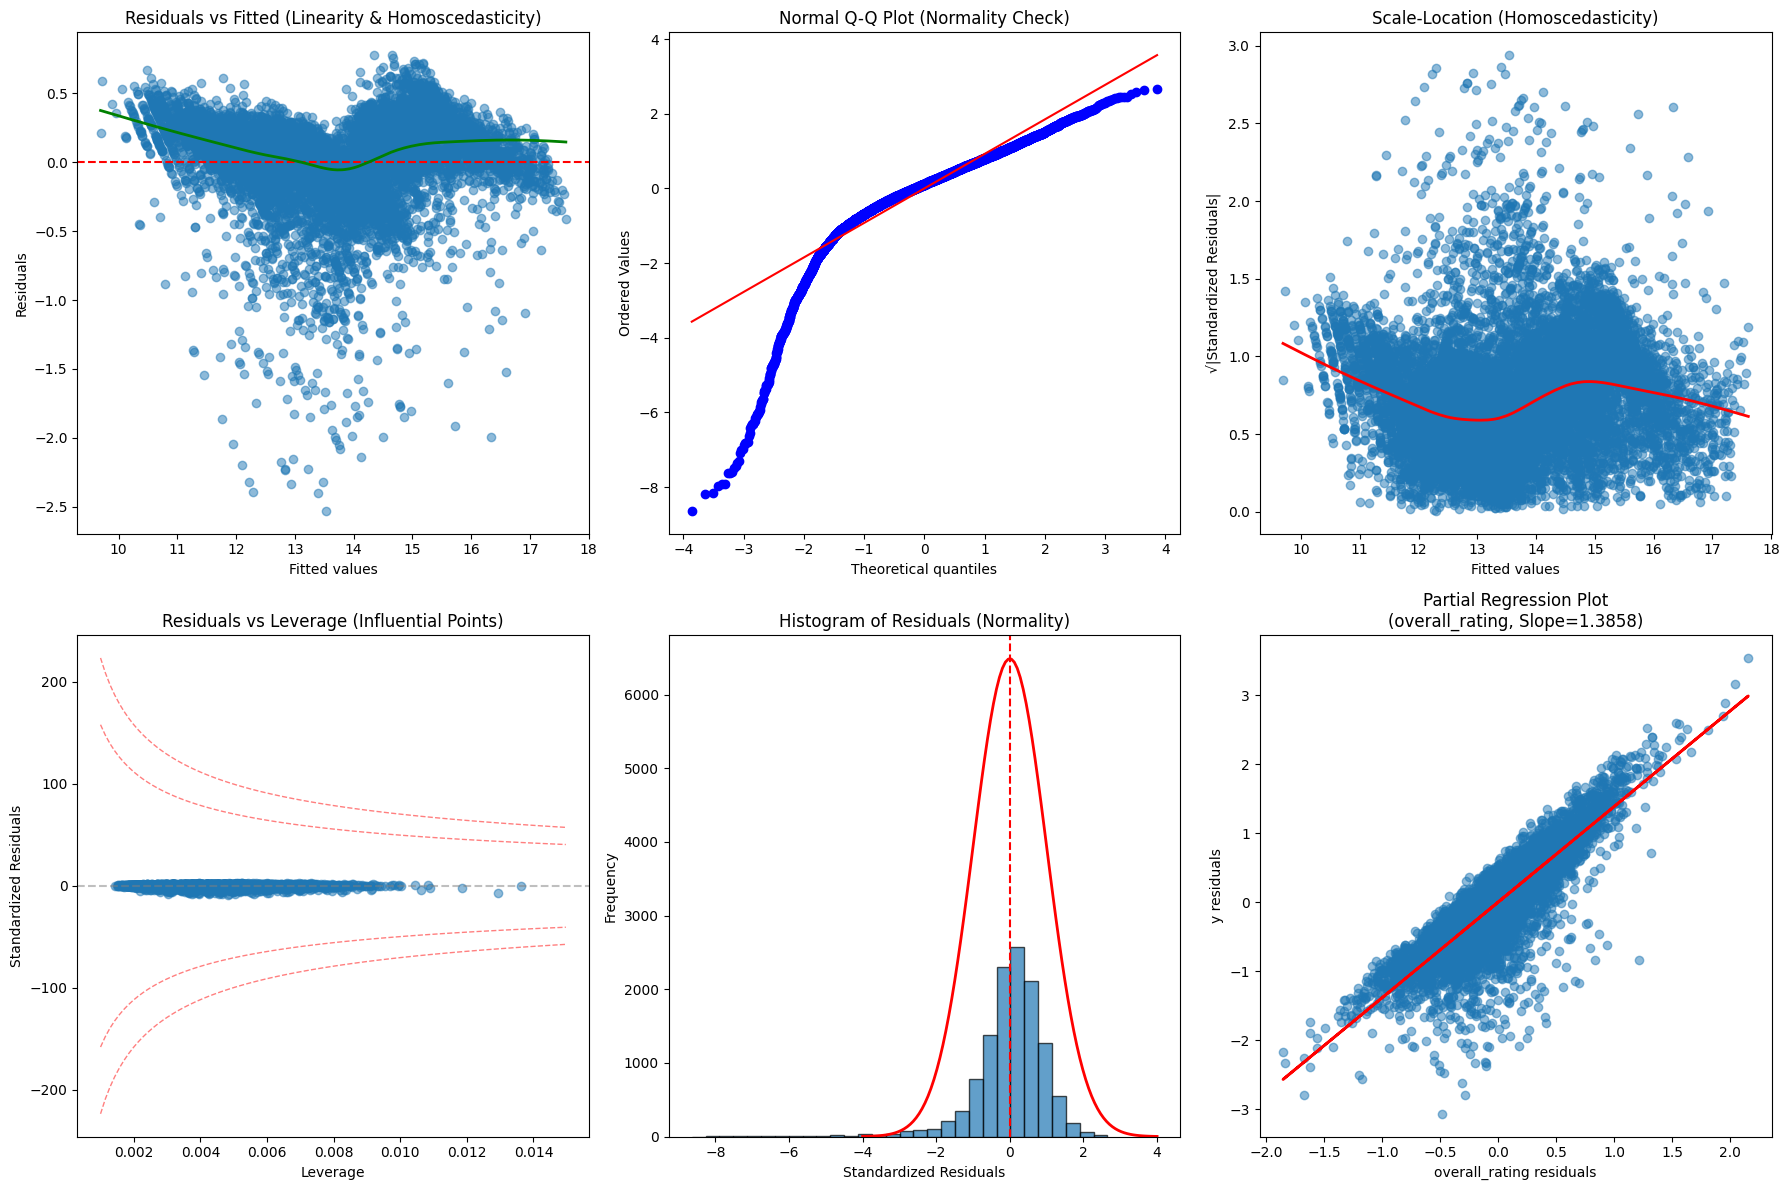


DIAGNOSTIC STATISTICS

--- Normality ---
Jarque-Bera test (Normality): JB = 66830.2940, p-value = 0.0000

--- Multicollinearity (VIF) ---

Features with HIGH MULTICOLLINEARITY (VIF ≥ 10):
  GK                  : 14.0352
Mean VIF: 2.9246

--- Autocorrelation ---
Durbin-Watson statistic (Autocorrelation): 1.9871

--- Heteroscedasticity ---
Breusch-Pagan test (Heteroscedasticity): LM = 1040.2334, p-value = 0.0000
White's test (Heteroscedasticity): LM = 3242.4833, p-value = 0.0000

--- Influential Points and Leverage ---
Maximum Cook's distance: 0.0123
Number of high leverage observations: 56
n: 12245
Rule of thumb (4/n): 0.0003
Number of observations with Cook's distance > 4/n: 564
=> Presence of highly influential points.
      COMPARISON: OLS (classical) vs HC3 (robust)
Feature         |    Coef. |     OLS SE |  OLS p>|t| |         OLS 95% CI |     HC3 SE |  HC3 p>|t| |         HC3 95% CI
--------------------------------------------------------------------------------------------------

In [147]:
model = NormalEquationOLS()
model.fit(X_train, y_train)

diagnostics = OLSDiagnostics(model)
diagnostics.plot_diagnostics()
diagnostics.print_robust_summary()

print(f"R2 (test set): {model.score(X_test, y_test):.4f}")
print(f"RMSE (test set): {model.get_rmse(X_test, y_test):.4f}")

### VIF correction

In [148]:
data.drop('GK', axis=1, inplace=True)

In [149]:
X = data.drop(columns=['full_name', 'log_value_euro'])
Y = data['log_value_euro']
for col in X.select_dtypes(include=['bool']).columns:
    X[col] = X[col].astype(int)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

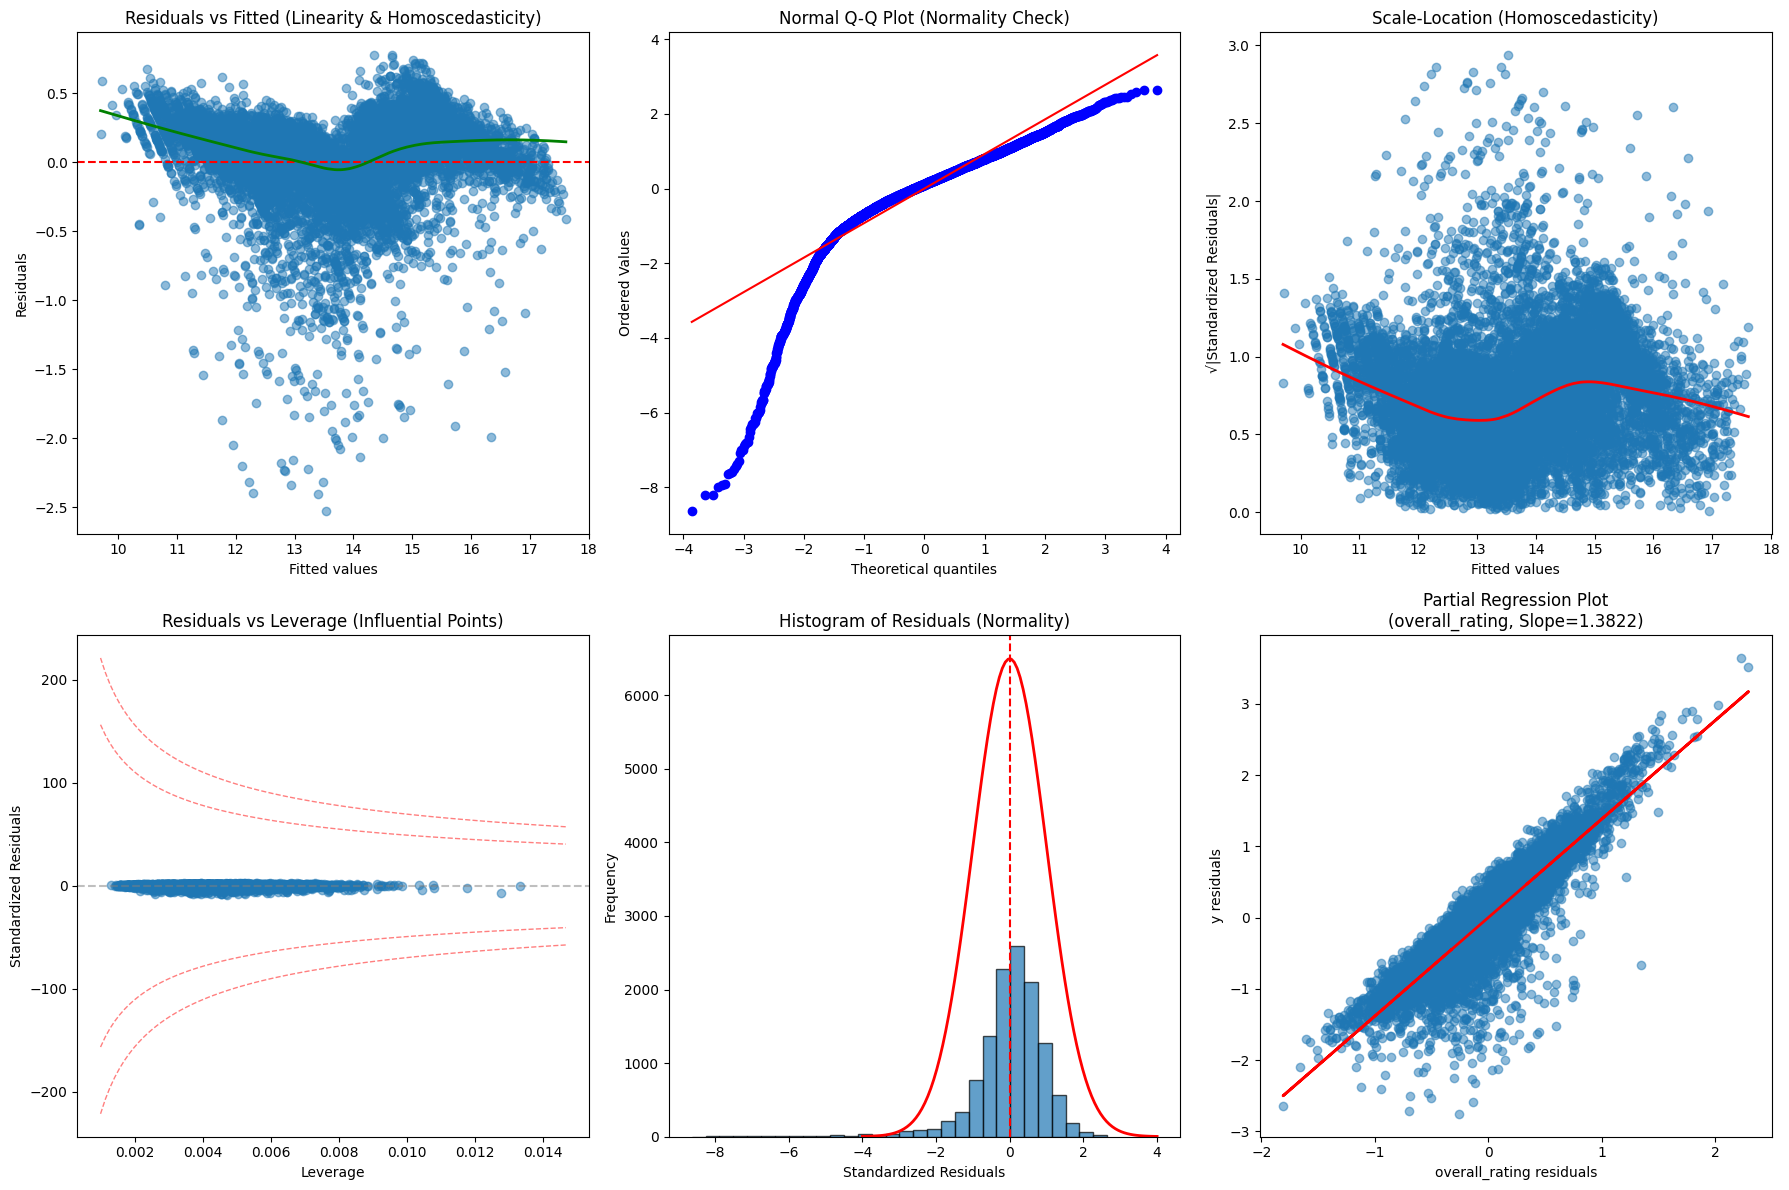


DIAGNOSTIC STATISTICS

--- Normality ---
Jarque-Bera test (Normality): JB = 66800.1962, p-value = 0.0000

--- Multicollinearity (VIF) ---

No features with HIGH MULTICOLLINEARITY (VIF ≥ 10).
Mean VIF: 2.5766

--- Autocorrelation ---
Durbin-Watson statistic (Autocorrelation): 1.9872

--- Heteroscedasticity ---
Breusch-Pagan test (Heteroscedasticity): LM = 1038.0042, p-value = 0.0000
White's test (Heteroscedasticity): LM = 3193.4775, p-value = 0.0000

--- Influential Points and Leverage ---
Maximum Cook's distance: 0.0123
Number of high leverage observations: 59
n: 12245
Rule of thumb (4/n): 0.0003
Number of observations with Cook's distance > 4/n: 560
=> Presence of highly influential points.
      COMPARISON: OLS (classical) vs HC3 (robust)
Feature         |    Coef. |     OLS SE |  OLS p>|t| |         OLS 95% CI |     HC3 SE |  HC3 p>|t| |         HC3 95% CI
------------------------------------------------------------------------------------------------------------------------
Interc

In [150]:
model = NormalEquationOLS()
model.fit(X_train, Y_train)

diagnostics = OLSDiagnostics(model)
diagnostics.plot_diagnostics()
diagnostics.print_robust_summary()

print(f"R2 (test set): {model.score(X_test, y_test):.4f}")
print(f"RMSE (test set): {model.get_rmse(X_test, y_test):.4f}")

### scipy.stats ols

In [151]:
X_train_with_const = sm.add_constant(X_train, prepend=True)
robust_results = sm.OLS(Y_train, X_train_with_const).fit()

print(robust_results.summary())

                            OLS Regression Results                            
Dep. Variable:         log_value_euro   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     5269.
Date:                Thu, 02 Oct 2025   Prob (F-statistic):               0.00
Time:                        07:54:46   Log-Likelihood:                -2311.6
No. Observations:               12245   AIC:                             4721.
Df Residuals:                   12196   BIC:                             5085.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [152]:
robust_results = sm.OLS(Y_train, X_train_with_const).fit(cov_type='HC3')

print(robust_results.summary())

                            OLS Regression Results                            
Dep. Variable:         log_value_euro   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     6559.
Date:                Thu, 02 Oct 2025   Prob (F-statistic):               0.00
Time:                        07:54:46   Log-Likelihood:                -2311.6
No. Observations:               12245   AIC:                             4721.
Df Residuals:                   12196   BIC:                             5085.
Df Model:                          48                                         
Covariance Type:                  HC3                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

## Robust Regression

### Model

In [153]:
class RobustRegressionIRLS:
    """
    Class for Robust Regression using Iteratively Reweighted Least Squares (Huber Loss).
    """
    def __init__(self, add_intercept=True, delta=1.0, max_iter=50, tol=1e-6):
        self.add_intercept = add_intercept
        self.delta = delta
        self.max_iter = max_iter
        self.tol = tol
        self.coefficients_ = None
        self.feature_names_ = None
        self.X_with_intercept_ = None
        self.y_ = None
        self.nobs_ = 0
        self.k_ = 0

    def fit(self, X, y, feature_names=None):
        """Fits the robust regression model using IRLS with Huber loss."""
        X_copy = X.copy()
        y_copy = y.copy()

        if isinstance(X_copy, pd.DataFrame):
            if feature_names is None:
                feature_names = X_copy.columns.tolist()
            X_copy = X_copy.values
        elif feature_names is None:
            feature_names = [f'x{i}' for i in range(X_copy.shape[1])]

        if isinstance(y_copy, pd.Series):
            y_copy = y_copy.values

        n, p = X_copy.shape

        # Add intercept
        if self.add_intercept:
            X_design = np.column_stack([np.ones(n), X_copy])
            self.feature_names_ = ['intercept'] + feature_names
        else:
            X_design = X_copy
            self.feature_names_ = feature_names

        self.X_with_intercept_ = X_design
        self.y_ = y_copy
        self.nobs_ = n
        self.k_ = X_design.shape[1]

        # Initial coefficients (OLS)
        beta = np.linalg.pinv(X_design) @ y_copy

        for iteration in range(self.max_iter):
            y_pred = X_design @ beta
            residuals = y_copy - y_pred

            # Huber weights
            abs_r = np.abs(residuals)
            weights = np.where(abs_r <= self.delta, 1.0, self.delta / abs_r)

            # Weighted least squares step
            W = np.diag(weights)
            XTWX = X_design.T @ W @ X_design
            XTWy = X_design.T @ W @ y_copy

            try:
                beta_new = np.linalg.solve(XTWX, XTWy)
            except np.linalg.LinAlgError:
                beta_new = np.linalg.pinv(XTWX) @ XTWy

            # Convergence check
            if np.max(np.abs(beta_new - beta)) < self.tol:
                beta = beta_new
                break
            beta = beta_new

        self.coefficients_ = beta
        return self

    def predict(self, X):
        """Predicts target values."""
        if self.coefficients_ is None:
            raise RuntimeError("Model is not fitted. Call fit first.")

        X_proc = X.copy()
        if isinstance(X_proc, pd.DataFrame):
            X_proc = X_proc.values

        if self.add_intercept:
            X_proc = np.column_stack([np.ones(X_proc.shape[0]), X_proc])

        return X_proc @ self.coefficients_

    def score(self, X, y):
        """R² score (Coefficient of Determination)"""
        y_pred = self.predict(X)
        if isinstance(y, (pd.Series, pd.DataFrame)):
            y = y.values
        tss = np.sum((y - np.mean(y))**2)
        rss = np.sum((y - y_pred)**2)
        return 1 - rss / tss if tss != 0 else 0.0

    def get_mse(self, X, y):
        """Mean Squared Error (MSE)"""
        y_pred = self.predict(X)
        if isinstance(y, (pd.Series, pd.DataFrame)):
            y = y.values
        return np.mean((y - y_pred)**2)

    def get_rmse(self, X, y):
        """Root Mean Squared Error (RMSE)"""
        return np.sqrt(self.get_mse(X, y))

    def get_stats(self):
        """Returns the statistics object for diagnostics."""
        if self.coefficients_ is None:
             raise RuntimeError("Model is not fitted.")
        return _OLSStats(self)


### Test

In [154]:
model_robust = RobustRegressionIRLS()
model_robust.fit(X_train, Y_train)

print(f"R2 (test set): {model_robust.score(X_test, y_test):.4f}")
print(f"RMSE (test set): {model_robust.get_rmse(X_test, y_test):.4f}")

R2 (test set): 0.9516
RMSE (test set): 0.2996


### Diagnostics

In [155]:
class _RobustStats:
    """Internal class for computing and storing necessary Robust Regression statistics."""
    def __init__(self, model: 'RobustRegressionIRLS'):
        self.model = model
        self.y_pred = self.model.X_with_intercept_ @ self.model.coefficients_
        self.residuals = self.model.y_ - self.y_pred

        # NOTE: RSS, TSS, R2, etc., are calculated on the unweighted data,
        # but the standard errors must be robustly estimated.

        # Sum of Squares (Unweighted)
        self.rss = np.sum(self.residuals**2)  # Residual Sum of Squares
        self.tss = np.sum((self.model.y_ - np.mean(self.model.y_))**2) # Total Sum of Squares
        self.ess = self.tss - self.rss  # Explained Sum of Squares

        # Degrees of freedom
        self.df_error = self.model.nobs_ - self.model.k_

        # R-squared (Unweighted)
        self.r2 = 1 - self.rss / self.tss
        self.r2_adj = 1 - (1 - self.r2) * (self.model.nobs_ - 1) / (self.df_error)

        # Variance estimate (sigma^2 - typically less meaningful in Robust Reg.)
        self.sigma_hat = np.sqrt(self.rss / self.df_error) if self.df_error > 0 else np.inf

        # Standardized residuals (for diagnostics)
        self.standardized_residuals = (
            self.residuals / self.sigma_hat if self.sigma_hat != np.inf else np.zeros_like(self.residuals)
        )

        # Huber weights (for diagnostics)
        abs_r = np.abs(self.residuals)
        self.weights = np.where(abs_r <= self.model.delta, 1.0, self.model.delta / abs_r)

        # --- Robust Standard Errors (Sandwich Estimator - WLS/Huber analogue of HC3) ---
        self.robust_std_err = self._calculate_robust_std_errors()


    def _calculate_robust_std_errors(self):
        """
        Computes the Robust Covariance Matrix for M-estimators (Sandwich Estimator).

        Formula: V_robust = (X'WX)^-1 * (X' Omega X) * (X'WX)^-1

        Where W is the final IRLS weight matrix and Omega is the inner variance matrix.
        For Huber M-estimator, Omega_ii = psi^2(e_i) / (w_i)^2
        A simpler, common approximation uses the final WLS step: Omega = W_final * Residuals^2 * W_final
        or simply e_i^2 (HC0) for simplicity in this context.
        We use the standard WLS-type sandwich form which is simpler to implement.
        """
        X = self.model.X_with_intercept_

        # Use the final IRLS weights W_final
        W_final = np.diag(self.weights)

        # 1. Outer part: (X' W X)^-1
        XTWX = X.T @ W_final @ X
        try:
            XTWX_inv = np.linalg.inv(XTWX)
        except np.linalg.LinAlgError:
             XTWX_inv = np.linalg.pinv(XTWX)

        # 2. Inner part: (X' Omega X) - Use WLS approximation with final weights
        # For simplicity, we use the WLS-equivalent sandwich (W_final * e^2 * W_final)
        weighted_e_sq = (self.residuals**2) * (self.weights**2)
        Omega_wls = np.diag(weighted_e_sq)
        middle_matrix = X.T @ Omega_wls @ X

        # 3. Sandwich: V = (X'WX)^-1 * (X' Omega X) * (X'WX)^-1
        robust_cov_matrix = XTWX_inv @ middle_matrix @ XTWX_inv

        return np.sqrt(np.diag(robust_cov_matrix))


class RobustDiagnostics:
    """
    Class for visualization and output of diagnostic statistics
    for a fitted RobustRegressionIRLS model.
    """
    def __init__(self, model: 'RobustRegressionIRLS'):
        self.model = model
        # NOTE: robust model should have an internal method to get its stats
        self.stats = _RobustStats(model)

    def plot_diagnostics(self):
        """Comprehensive diagnostic plots for Robust Regression."""

        y_pred = self.stats.y_pred
        residuals = self.stats.residuals
        standardized_residuals = self.stats.standardized_residuals
        weights = self.stats.weights

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # --- Residuals vs Fitted (Unweighted) ---
        axes[0, 0].scatter(y_pred, residuals, alpha=0.5)
        axes[0, 0].axhline(0, color='r', linestyle='--')
        lowess_result = lowess(residuals, y_pred, frac=0.6)
        axes[0, 0].plot(lowess_result[:, 0], lowess_result[:, 1], 'g-', linewidth=2)
        axes[0, 0].set_xlabel('Fitted values')
        axes[0, 0].set_ylabel('Residuals')
        axes[0, 0].set_title('Residuals vs Fitted (Unweighted)')

        # --- Normal Q-Q Plot ---
        stats.probplot(standardized_residuals, dist="norm", plot=axes[0, 1])
        axes[0, 1].set_title('Normal Q-Q Plot of Residuals')

        # --- Residuals vs Huber Weights (KEY Robust Diagnostic) ---
        axes[1, 0].scatter(weights, residuals, alpha=0.5)
        axes[1, 0].axhline(0, color='r', linestyle='--')
        axes[1, 0].axvline(self.model.delta / np.max(np.abs(residuals)) if np.max(np.abs(residuals)) > 0 else 0,
                           color='gray', linestyle=':', label='delta/|r_max|')
        axes[1, 0].axvline(1.0, color='g', linestyle='-', linewidth=2, label='Huber Threshold')
        axes[1, 0].set_xlabel('Huber Weight (W_i)')
        axes[1, 0].set_ylabel('Residuals')
        axes[1, 0].set_title(f'Residuals vs Huber Weights (Delta={self.model.delta})')
        axes[1, 0].legend()

        # --- Standardized Residuals vs Fitted (Scaled) ---
        sqrt_abs_std_resid = np.sqrt(np.abs(standardized_residuals))
        axes[1, 1].scatter(y_pred, sqrt_abs_std_resid, alpha=0.5)
        lowess_sl = lowess(sqrt_abs_std_resid, y_pred, frac=0.6)
        axes[1, 1].plot(lowess_sl[:, 0], lowess_sl[:, 1], 'r-', linewidth=2)
        axes[1, 1].set_xlabel('Fitted values')
        axes[1, 1].set_ylabel('√|Standardized Residuals|')
        axes[1, 1].set_title('Scale-Location (Homoscedasticity Check)')

        plt.tight_layout()
        plt.show()
        self.print_robust_summary()

    def print_robust_summary(self, alpha=0.05):
        """Prints the robust regression summary with robust standard errors."""

        coeffs = self.model.coefficients_
        robust_se = self.stats.robust_std_err
        df = self.stats.df_error
        t_crit = stats.t.ppf(1 - alpha/2, df=df)

        # t-stats and p-values based on Robust SE
        robust_t = coeffs / robust_se
        robust_p = 2 * (1 - stats.t.cdf(np.abs(robust_t), df=df))

        # Confidence intervals
        robust_ci_low, robust_ci_high = coeffs - t_crit*robust_se, coeffs + t_crit*robust_se

        feature_names = self.model.feature_names_

        print("\n" + "="*80)
        print("      ROBUST REGRESSION SUMMARY (IRLS with Huber Loss)")
        print("="*80)

        # --- Model Metrics ---
        print(f"R-squared (unweighted): {self.stats.r2:.4f}")
        print(f"Adj. R-squared (unweighted): {self.stats.r2_adj:.4f}")
        print(f"Observations (n): {self.model.nobs_}, Predictors (k): {self.model.k_}")
        print(f"Huber Delta: {self.model.delta}")

        print("\n" + "-"*80)
        header = (
            f"{'Feature':<15} | {'Coef.':>8} | "
            f"{'Robust SE':>12} | {'t-statistic':>12} | {'p>|t|':>10} | {'95% CI':>18}"
        )
        print(header)
        print("-"*len(header))

        for i in range(self.model.k_):
            print(
                f"{feature_names[i]:<15} | {coeffs[i]:>8.4f} | "
                f"{robust_se[i]:>12.4f} | {robust_t[i]:>12.4f} | {robust_p[i]:>10.4f} | "
                f"[{robust_ci_low[i]:>8.4f}, {robust_ci_high[i]:>8.4f}]"
            )
        print("="*80)

        # --- Additional Diagnostics ---
        self._print_robust_diagnostics()

    def _print_robust_diagnostics(self):
        """Prints diagnostics relevant to the robust model."""
        residuals = self.stats.residuals

        print("\n--- Additional Diagnostics (Unweighted Residuals) ---")

        # Normality (still relevant, but less critical)
        jb_stat, jb_p = stats.jarque_bera(residuals)
        print(f"Jarque-Bera test (Normality): p-value = {jb_p:.4f} (Model aims for robust coefs, not normal errors)")

        # Autocorrelation
        dw_stat = durbin_watson(residuals)
        print(f"Durbin-Watson statistic (Autocorrelation): {dw_stat:.4f}")

        # Heteroscedasticity
        try:
            bp_stat, bp_p, _, _ = het_breuschpagan(residuals, self.model.X_with_intercept_)
            print(f"Breusch-Pagan test (Heteroscedasticity): p-value = {bp_p:.4f}")
        except Exception:
            print("Breusch-Pagan test failed.")

        # Multicollinearity
        k = self.model.k_
        if k > 1:
            try:
                # VIF must be calculated on the UNWEIGHTED X matrix
                X_design_no_intercept = self.model.X_with_intercept_[:, 1:]
                vif_values = [variance_inflation_factor(X_design_no_intercept, i) for i in range(X_design_no_intercept.shape[1])]
                feature_names_no_intercept = self.model.feature_names_[1:k]
                mean_vif = np.mean(vif_values)
                print(f"Mean VIF (Multicollinearity): {mean_vif:.4f}")
            except Exception as e:
                print(f"VIF calculation failed: {e}")


In [156]:
robust_diag = RobustDiagnostics(model_robust)


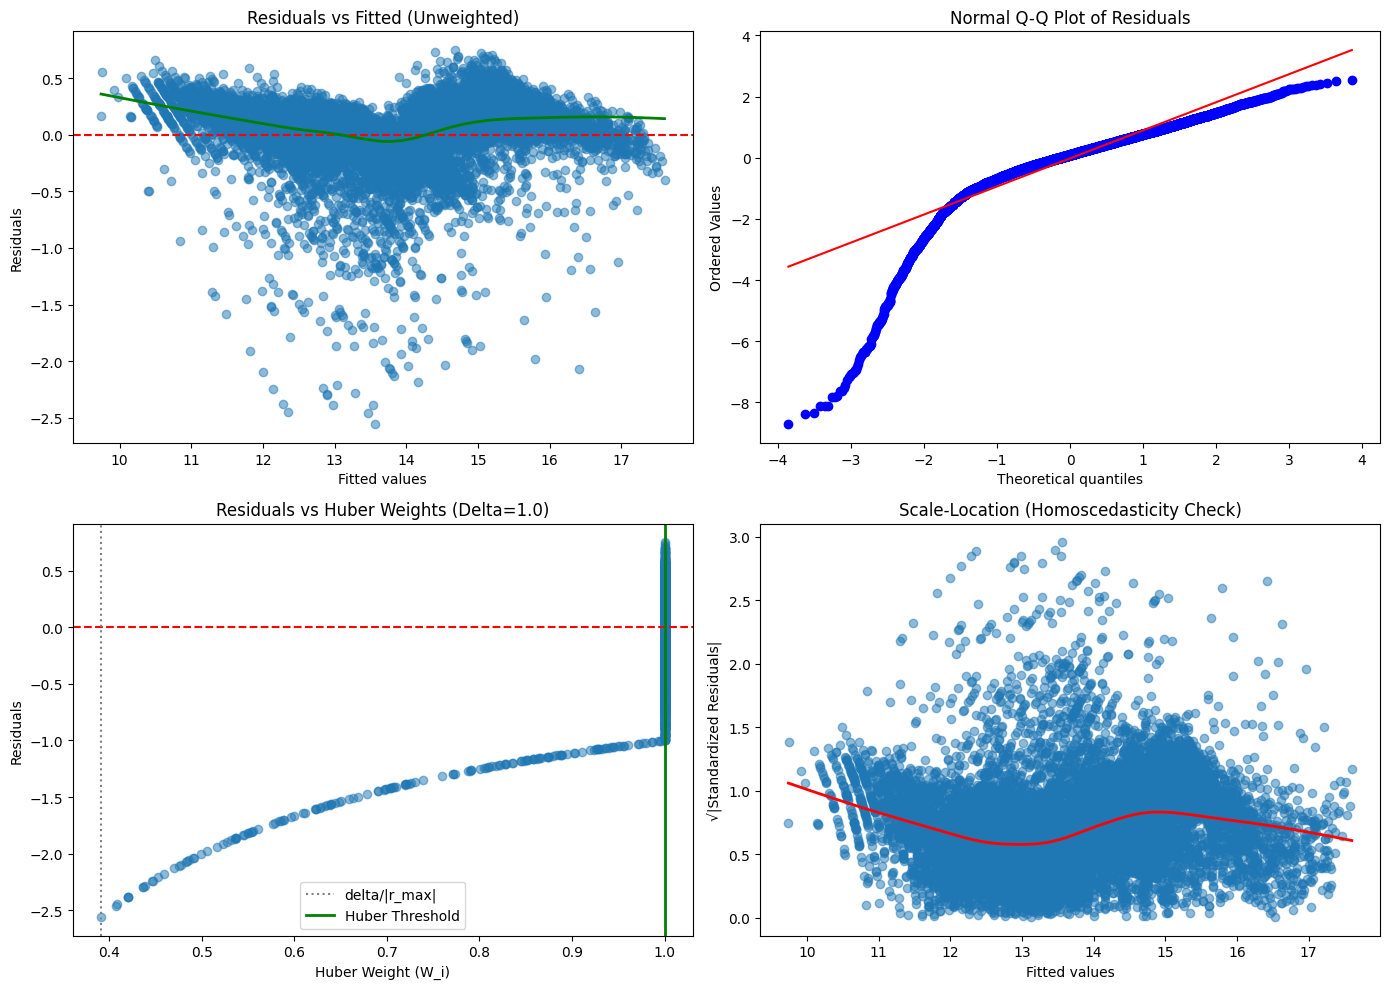


      ROBUST REGRESSION SUMMARY (IRLS with Huber Loss)
R-squared (unweighted): 0.9539
Adj. R-squared (unweighted): 0.9537
Observations (n): 12245, Predictors (k): 49
Huber Delta: 1.0

--------------------------------------------------------------------------------
Feature         |    Coef. |    Robust SE |  t-statistic |      p>|t| |             95% CI
------------------------------------------------------------------------------------------
intercept       |  13.6334 |       0.0078 |    1749.3482 |     0.0000 | [ 13.6182,  13.6487]
weight_kgs      |   0.0022 |       0.0042 |       0.5207 |     0.6026 | [ -0.0060,   0.0103]
overall_rating  |   1.3870 |       0.0061 |     227.6226 |     0.0000 | [  1.3751,   1.3990]
international_reputation(1-5) |  -0.0230 |       0.0037 |      -6.2223 |     0.0000 | [ -0.0303,  -0.0158]
weak_foot(1-5)  |  -0.0031 |       0.0027 |      -1.1492 |     0.2505 | [ -0.0083,   0.0022]
skill_moves(1-5) |   0.0417 |       0.0045 |       9.1770 |     0.0000 | 

In [157]:
robust_diag.plot_diagnostics()

# Summary

## Regression Analysis of FIFA 2023 Player Data

A preliminary preprocessing of the dataset containing FIFA 2023 player statistics was carried out. At the experimental stage, different types of regression models were explored. Using **scikit-learn**, the following models were compared:

- **Ordinary Least Squares (OLS):**  
  Test RMSE = 0.298992,  
  Test $R^2 = 0.951852$

- **Lasso Regression (L1 regularization):**  
  Test RMSE = 0.298830,  
  Test $R^2 = 0.951872$

- **Ridge Regression (L2 regularization):**  
  Test RMSE = 0.298881,  
  Test $R^2 = 0.951856$

- **Elastic Net (L1+L2 regularization):**  
  Test RMSE = 0.298842,  
  Test $R^2 = 0.951868$

All models demonstrated high performance, with no significant differences observed. This can be explained by the high quality of the data, characterized by informative features and low noise.

Additionally, the **XGBoost regression model**, based on gradient boosting of decision trees, was tested. Hyperparameters were optimized using Bayesian Optimization (Optuna). The optimal configuration was:

- `n_estimators`: 1000  
- `max_depth`: 4  
- `learning_rate`: 0.0306  
- `subsample`: 0.6612  
- `colsample_bytree`: 0.8117  
- `reg_alpha`: 0.9986  
- `reg_lambda`: 4.21e-07  

The final results of XGBoost were:

$$
R^2_{\text{test}} = 0.9757, \quad RMSE_{\text{test}} = 0.2125
$$

For validation, a custom implementation of **OLS regression** was also developed without using ready-made library functions. The results matched the scikit-learn implementation:

$$
R^2_{\text{test}} = 0.9518, \quad RMSE_{\text{test}} = 0.2989
$$

### Diagnostic Analysis

A diagnostic analysis of the OLS model revealed:

- Non-normality of residuals (Jarque-Bera test)  
- Multicollinearity (resolved by removing one highly correlated feature)  
- Homoscedasticity of residuals (assumption was met)  
- Presence of high-influence points (outliers/leverage points)  

### Corrections Applied

To address these issues:

- **HC3 robust standard errors (White’s robust errors)** were applied to correct statistical inference in the presence of heteroscedasticity and non-normality.  
- **Robust Regression with Iteratively Reweighted Least Squares (IRLS)** using the **Huber loss** function was implemented to mitigate the impact of influential points and outliers.
